#Assessing the Role of Machine Learning in Climate Research Publications
Andreea-Mihaela Niculae*, Simona-Vasilica Oprea, Alin-Gabriel Văduva, Adela Bâra and Anca-Ioana Andreescu



Web of Science query for manual download: <br> (ALL=(climate *) AND ALL=(machine learning )) AND ((DT==("ARTICLE") AND OA==("OPEN ACCESS") AND LA==("ENGLISH")) NOT (EN==("RETRACTED PUBLICATION") OR PY==("2025")))

### Python packages

In [1]:
!pip install node2vec
!pip install nltk
!pip install pyldavis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
from pandas.api.types import is_string_dtype
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import display, HTML
from matplotlib.ticker import StrMethodFormatter
from IPython.display import Image
import plotly.express as px
from wordcloud import WordCloud
from collections import defaultdict
import networkx as nx
from sklearn.cluster import KMeans
import numpy as np
from node2vec import Node2Vec
from sklearn.cluster import DBSCAN
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk import bigrams
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models import LdaModel  # one possible LDA implementation (not the only one)
from gensim.models.coherencemodel import CoherenceModel
from gensim.matutils import corpus2csc
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import string
import spacy
import pickle
import re

import pyLDAvis
import pyLDAvis.gensim

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Exploratory Data Analysis (EDA)

In [3]:
# Load data
climate = pd.read_excel('Climate_ML.xlsx', sheet_name='Sheet1') # manual download
bibliometrics = pd.read_excel('Bibliometrix-Export-File.xlsx', sheet_name='Sheet 1') # obtained from bibliometrics in R

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# View variables
# Important to note: WoS provides datasets with 72 bibliometric information (variables).
# Multiple columns have information not uf use for us; the rest were manually eliminated before introduced in python
# Only 30 columns remained for Python / R analysis
print(climate.columns)

Index(['Publication Type', 'Authors', 'Author Full Names', 'Article Title',
       'Source Title', 'Author Keywords', 'Keywords Plus', 'Abstract',
       'Addresses', 'Affiliations', 'Reprint Addresses', 'Email Addresses',
       'Times Cited, WoS Core', 'Times Cited, All Databases',
       '180 Day Usage Count', 'Since 2013 Usage Count', 'Publication Date',
       'Publication Year', 'Volume', 'Issue', 'Article Number', 'DOI',
       'DOI Link', 'WoS Categories', 'Research Areas',
       'Open Access Designations', 'Highly Cited Status', 'Hot Paper Status',
       'Date of Export', 'Web of Science Record'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
print(bibliometrics.columns) # all original columns; also contains country

Index(['AU', 'AF', 'AB', 'AR', 'BE', 'BN', 'BP', 'C1', 'C3', 'CA', 'CL', 'CT',
       'CY', 'DA', 'DE', 'DI', 'DT', 'EA', 'EF', 'EI', 'EM', 'EP', 'ER', 'FU',
       'FX', 'GA', 'HO', 'ID', 'IS', 'J9', 'JI', 'LA', 'NR', 'OA', 'OI', 'PA',
       'PD', 'PG', 'PI', 'PM', 'PN', 'PT', 'PU', 'PY', 'RI', 'RP', 'SC', 'SE',
       'SI', 'SN', 'SO', 'SP', 'SU', 'TC', 'TI', 'U1', 'U2', 'UT', 'VL', 'WC',
       'WE', 'Z9', 'C1raw', 'DB', 'CR', 'AU_UN', 'AU1_UN', 'AU_UN_NR',
       'SR_FULL', 'SR', 'AU_CO'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
## Prepare the cleaning
# We will work on the climate dataset and, where needed, changes will be made in the bibliometrics dataset

## Find missing values
print("Original")
print(climate.isnull().sum())

## Remove columns with more than 50% missing values => remove redundancies
missing_percentage = climate.isnull().sum() * 100 / len(climate)
columns_to_drop = missing_percentage[missing_percentage > 50].keys()
climate = climate.drop(columns_to_drop, axis=1)

## Treat missing values
# Replace missing values
climate['Publication Year'].fillna(round(climate['Publication Year'].mean()), inplace=True)
climate['Times Cited, WoS Core'].fillna(0, inplace=True)
climate['Times Cited, All Databases'].fillna(0, inplace=True)

for col in climate.columns:
    if is_string_dtype(climate[col]):
        climate[col].fillna('Missing data', inplace=True)
    else:
        climate[col].fillna(0, inplace=True)

print("Final")
print(climate.isnull().sum())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-4-1da86d76d733>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  climate['Publication Year'].fillna(round(climate['Publication Year'].mean()), inplace=True)
<ipy

Original
Publication Type                 0
Authors                          0
Author Full Names                0
Article Title                    0
Source Title                     0
Author Keywords               1156
Keywords Plus                  508
Abstract                         4
Addresses                        5
Affiliations                   147
Reprint Addresses                6
Email Addresses                 68
Times Cited, WoS Core            0
Times Cited, All Databases       0
180 Day Usage Count              0
Since 2013 Usage Count           0
Publication Date               424
Publication Year                 0
Volume                         120
Issue                         2323
Article Number                2217
DOI                              7
DOI Link                         7
WoS Categories                   0
Research Areas                   0
Open Access Designations         0
Highly Cited Status           7519
Hot Paper Status              7519
Date of Exp

In [27]:
## Take a sample of 10 articles to check for validity
# first 10 for easy verification
sample = climate.head(10)
sample

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Publication Type                                            Authors  \
0                J  Saleh, RA; Al-Areeq, AM; Al Aghbari, AA; Ghale...   
1                J                               Aishi, AF; Fahim, AF   
2                J  Ayari, E; Kassouk, Z; Lili-Chabaane, Z; Ouaadi...   
3                J                   Estrada-Peña, A; de la Fuente, J   
4                J  Foong, LK; Blazek, V; Prokop, L; Misak, S; Ata...   
5                J  Francini, S; Vangi, E; D'Amico, G; Borghi, C; ...   
6                J               Gumma, MK; Panjala, P; Teluguntla, P   
7                J                     Ha, TV; Uereyen, S; Kuenzer, C   
8                J  Hu, ZY; Yan, DZ; Feng, M; Xu, JH; Liang, SH; S...   
9                J  Khosravi, K; Farooque, AA; Bateni, SM; Jun, C;...   

                                   Author Full Names  \
0  A. Saleh, Radhwan; Al-Areeq, Ahmed M.; Al Aghb...   
1     Aishi, Aishia Fyruz; Fahim, Abul Kashem Faruki   
2  Ayari, Emna; Kassouk, Zeineb; Lili-Chabaane, Z...   
3          Estrada-Pena, Agustin; de la Fuente, Jose   
4  Foong, Loke Kok; Blazek, Vojtech; Prokop, Luka...   
5  Francini, Saverio; Vangi, Elia; D'Amico, Giova...   
6  Gumma, Murali Krishna; Panjala, Pranay; Telugu...   
7     Ha, Tuyen V.; Uereyen, Soner; Kuenzer, Claudia   
8  Hu, Zhongyi; Yan, Dezhao; Feng, Min; Xu, Jinha...   
9  Khosravi, Khabat; Farooque, Aitazaz A.; Bateni...   

                                       Article Title  \
0  A novel voting ensemble model empowered by met...   
1  Analyzing the association between the hydrodyn...   
2  NDVI estimation using Sentinel-1 data over whe...   
3  Machine learning algorithms for the evaluation...   
4  Improve carbon dioxide emission prediction in ...   
5  Field-independent carbon mapping and quantific...   
6  Mapping heterogeneous land use/land cover and ...   
7  Spatiotemporal analysis of tropical vegetation...   
8  Enhancing mountainous permafrost mapping by le...   
9  Fluvial bedload transport modelling: advanced ...   

                                        Source Title  \
0                   GEOMATICS NATURAL HAZARDS & RISK   
1                   GEOMATICS NATURAL HAZARDS & RISK   
2                         GISCIENCE & REMOTE SENSING   
3                                 ANNALS OF MEDICINE   
4  ENGINEERING APPLICATIONS OF COMPUTATIONAL FLUI...   
5                 EUROPEAN JOURNAL OF REMOTE SENSING   
6             INTERNATIONAL JOURNAL OF DIGITAL EARTH   
7                         GISCIENCE & REMOTE SENSING   
8             INTERNATIONAL JOURNAL OF DIGITAL EARTH   
9  ENGINEERING APPLICATIONS OF COMPUTATIONAL FLUI...   

                                     Author Keywords  \
0  Remote sensing; feature selection; deep learni...   
1  Bangladesh; monsoon floods; riverbank erosion;...   
2  Synthetic aperture radar; normalized differenc...   
3  Tick habitat suitability; modelling; Europe; h...   
4  CO2 emission; environmental policy; metaheuris...   
5  Sentinel-2; forest; Google Earth Engine; machi...   
6  Cropping pattern; sentinel-2; machine learning...   
7  Undisturbed ecosystems; drivers; remote sensin...   
8  Mountainous permafrost; rock glacier; northeas...   
9  Bedload sediment; machine learning; empirical ...   

                                       Keywords Plus  \
0                                   WEIGHTS; MACHINE   
1  NEURAL-NETWORKS; MODEL; PREDICTION; VARIABLES;...   
2  SURFACE MOISTURE ESTIMATION; TIME-SERIES DATA;...   
3  NULL MODELS; HABITAT; CLIMATE; SUITABILITY; VA...   
4                                      CO2 EMISSIONS   
5  TASSELED CAP TRANSFORMATION; LANDSAT TIME-SERI...   
6  TIME-SERIES; RANDOM FOREST; FOOD SECURITY; EXT...   
7  LAND-COVER CHANGE; MODIS NDVI; BRIGHTNESS TEMP...   
8  ACTIVE-LAYER THICKNESS; THERMAL STATE; CLIMATE...   
9  BED-LOAD TRANSPORT; SUPPORT VECTOR REGRESSION;...   

                                            Abstract  \
0  This study addresses the challenges of flash f...   
1

In [5]:
## Standardize = make all information in caps
for col in climate.columns:
    if is_string_dtype(climate[col]):
        climate[col] = climate[col].str.upper()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
## Identify and remove duplicates based on Title and DOI
duplicate_titles_DOI = climate[climate.duplicated(subset=['Article Title', 'DOI'], keep=False)]
duplicate_titles_DOI # there are no duplicates for this pair

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Empty DataFrame
Columns: [Publication Type, Authors, Author Full Names, Article Title, Source Title, Author Keywords, Keywords Plus, Abstract, Addresses, Affiliations, Reprint Addresses, Email Addresses, Times Cited, WoS Core, Times Cited, All Databases, 180 Day Usage Count, Since 2013 Usage Count, Publication Date, Publication Year, Volume, Issue, Article Number, DOI, DOI Link, WoS Categories, Research Areas, Open Access Designations, Date of Export, Web of Science Record]
Index: []

[0 rows x 28 columns]

## 1. Publications per year

In [38]:
publications_per_year = climate.groupby('Publication Year')['Publication Year'].count()
total = len(climate)
percentage = (publications_per_year / total) * 100

total_citations = climate['Times Cited, All Databases'].sum()
citations_per_year = climate.groupby('Publication Year')['Times Cited, All Databases'].sum()
average_citations_per_year = (citations_per_year / total_citations) * 100
median_citations_per_year = climate.groupby('Publication Year')['Times Cited, All Databases'].median()
average_citations_per_article = climate.groupby('Publication Year')['Times Cited, All Databases'].mean()

table_1 = pd.DataFrame({
    'Number of Publications': publications_per_year,
    'Percentage of Total Publications': round(percentage,2),
    'Citations per Year': citations_per_year,
    'Average citations per Year': round(average_citations_per_year,2),
    'Median citations per Year': median_citations_per_year,
    'Average citations per Article': round(average_citations_per_article,2)
})

display(table_1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of Publications  Percentage of Total Publications  \
Publication Year                                                             
2004                                   3                              0.04   
2005                                   5                              0.07   
2006                                   3                              0.04   
2007                                   2                              0.03   
2008                                   1                              0.01   
2009                                   6                              0.08   
2010                                   4                              0.05   
2011                                  14                              0.19   
2012                                  13                              0.17   
2013                                  17                              0.23   
2014                                  27                              0.36   
2015                                  30                              0.40   
2016                                  66                              0.88   
2017                                  88                              1.17   
2018                                 173                              2.30   
2019                                 337                              4.48   
2020                                 658                              8.75   
2021                                1046                             13.91   
2022                                1493                             19.86   
2023                                1812                             24.10   
2024                                1721                             22.89   

                  Citations per Year  Average citations per Year  \
Publication Year                                                   
2004                            1175                        0.82   
2005                             103                        0.07   
2006                             398                        0.28   
2007                             447                        0.31   
2008                              54                        0.04   
2009                            2592                        1.80   
2010                             240                        0.17   
2011                            2058                        1.43   
2012                            1311                        0.91   
2013                            8222                        5.72   
2014                            2064                        1.44   
2015                            1684                        1.17   
2016                            7701                        5.36   
2017                            7517                        5.23   
2018                           10177                        7.08   
2019                           14914                       10.37   
2020                           25441                       17.69   
2021                           24790                       17.24   
2022                           19988                       13.90   
2023                           10614                        7.38   
2024                            2316                        1.61   

                  Median citations per Year  Average citations per Article  
Publication Year                                                            
2004                                  404.0                         391.67  
2005                                   12.0                          20.60  
2006                                   75.0                         132.67  
2007                                  223.5                         223.50  
2008                                   54.0                          54.00  
2009                                  343.0                         432.00  
2010                                   54.

## 2. Bibliometric results
Here you can only find text, as the results are from another software.

In [ ]:
"""
 Timespan                              2004 : 2024
 Sources (Journals, Books, etc)        1356
 Documents                             7521
 Annual Growth Rate %                  37.39
 Document Average Age                  2.11
 Average citations per doc             17.87
 Average citations per year per doc    4.152
 References                            1
"""

In [ ]:
"""
DOCUMENT TYPES
 article                         7299
 article; book chapter           3
 article; data paper             78
 article; early access           109
 article; proceedings paper      32

DOCUMENT CONTENTS
 Keywords Plus (ID)                    11345
 Author's Keywords (DE)                17103

AUTHORS
 Authors                               32604
 Author Appearances                    45767
 Authors of single-authored docs       142

AUTHORS COLLABORATION
 Single-authored docs                  149
 Documents per Author                  0.231
 Co-Authors per Doc                    6.09
 International co-authorships %        42.93
"""

In [ ]:
"""
Most Productive Authors

   Authors        Articles Authors        Articles Fractionalized
1       PRADHAN B       65      PRADHAN B                   14.50
2       ZHANG Y         45      BARNES EA                    7.19
3       LIU Y           41      KIM S                        6.99
4       MOSAVI A        37      ZHANG Y                      6.95
5       CHEN Y          34      LIU Y                        6.64
6       WANG Y          31      MOSAVI A                     6.31
7       LI J            30      CHEN Y                       5.71
8       WANG J          29      LI J                         5.39
9       KIM S           28      LEE S                        5.08
10      LI X            27      WANG Y                       5.04
"""

In [ ]:
"""
Corresponding Author's Countries

          Country Articles   Freq  SCP MCP MCP_Ratio
1  USA                1482 0.1983 1028 454     0.306
2  CHINA              1389 0.1859  893 496     0.357
3  GERMANY             621 0.0831  343 278     0.448
4  UNITED KINGDOM      341 0.0456  128 213     0.625
5  AUSTRALIA           285 0.0381  118 167     0.586
6  CANADA              258 0.0345  154 104     0.403
7  ITALY               230 0.0308  129 101     0.439
8  KOREA               213 0.0285  133  80     0.376
9  SPAIN               213 0.0285  126  87     0.408
10 INDIA               205 0.0274  141  64     0.312

SCP: Single Country Publications
MCP: Multiple Country Publications
"""

In [ ]:
"""
Total Citations per Country

      Country      Total Citations Average Article Citations
1  USA                       35144                    23.714
2  CHINA                     18820                    13.549
3  GERMANY                   18029                    29.032
4  UNITED KINGDOM             6406                    18.786
5  AUSTRALIA                  6205                    21.772
6  CANADA                     4449                    17.244
7  ITALY                      3823                    16.622
8  KOREA                      3117                    14.634
9  SPAIN                      2812                    13.202
10 INDIA                      2603                    12.698
"""

In [ ]:
"""
Most Relevant Keywords

   Author Keywords (DE)      Articles Keywords-Plus (ID)     Articles
1    MACHINE LEARNING            3061         CLIMATE-CHANGE      941
2    CLIMATE CHANGE               608         MODEL               844
3    RANDOM FOREST                481         CLIMATE             792
4    REMOTE SENSING               454         PREDICTION          601
5    DEEP LEARNING                373         CLASSIFICATION      531
6    ARTIFICIAL INTELLIGENCE      246         TEMPERATURE         454
7    PREDICTION                   119         IMPACT              400
8    NEURAL NETWORKS              103         VARIABILITY         385
9    CLIMATE                      100         MODELS              362
10   CLASSIFICATION                97         REGRESSION          340
"""

In [ ]:
"""
AUTHOR DOMINANCE
     Author Dominance Factor Tot Articles Single-Authored Multi-Authored First-Authored Rank by Articles Rank by DF
1     CHEN Y       0.26470588           34               0             34              9                5          1
2      KIM S       0.25000000           28               0             28              7                9          2
3       LI X       0.22222222           27               0             27              6               10          3
4      LIU Y       0.19512195           41               0             41              8                3          4
5     WANG Y       0.16129032           31               0             31              5                6          5
6    ZHANG Y       0.15555556           45               0             45              7                2          6
7   MOSAVI A       0.13513514           37               0             37              5                4          7
8     WANG J       0.10344828           29               0             29              3                8          8
9       LI J       0.06666667           30               0             30              2                7          9
10 PRADHAN B       0.06153846           65               0             65              4                1         10
"""

In [ ]:
"""
SOURCE IMPACT
Source          	h_index	  g_index	  m_index	    TC	    NP	  PY_start
REMOTE SENSING	  49	      77	      4.455	      11131	  625	  2014
REMOTE SENSING OF ENVIRONMENT	40	67	2.857	4670	93	2011
SCIENTIFIC REPORTS	31	53	3.444	3498	167	2016
ENVIRONMENTAL RESEARCH LETTERS	30	61	1.875	4006	133	2009
SCIENCE OF THE TOTAL ENVIRONMENT	28	44	3.5	2352	104	2017
SENSORS	25	35	2.273	1614	102	2014
WATER	25	39	3.125	2122	163	2017
JOURNAL OF ADVANCES IN MODELING EARTH SYSTEMS	24	46	3	2363	120	2017
NATURE COMMUNICATIONS	23	45	3.833	2087	54	2019
PLOS ONE	22	42	1.467	1838	74	2010
"""

In [ ]:
"""
AUTHOR IMPACT
Author	h_index	g_index	m_index	TC	NP	PY_start
MOSAVI A	24	37	4	1963	37	2019
PRADHAN B	23	34	4.6	1339	65	2020
CAMPS-VALLS G	16	26	1.6	2175	26	2015
LEE S	16	26	2.286	812	26	2018
ZHANG Y	15	38	1.25	1488	45	2013
DEO RC	13	15	1.625	454	15	2017
IM J	13	19	1.444	653	19	2016
LIU Y	13	22	1.444	532	41	2016
PAL SC	13	13	2.6	789	13	2020
YASEEN ZM	13	23	2.167	570	25	2019
"""

### Bibliometric plots (photos)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



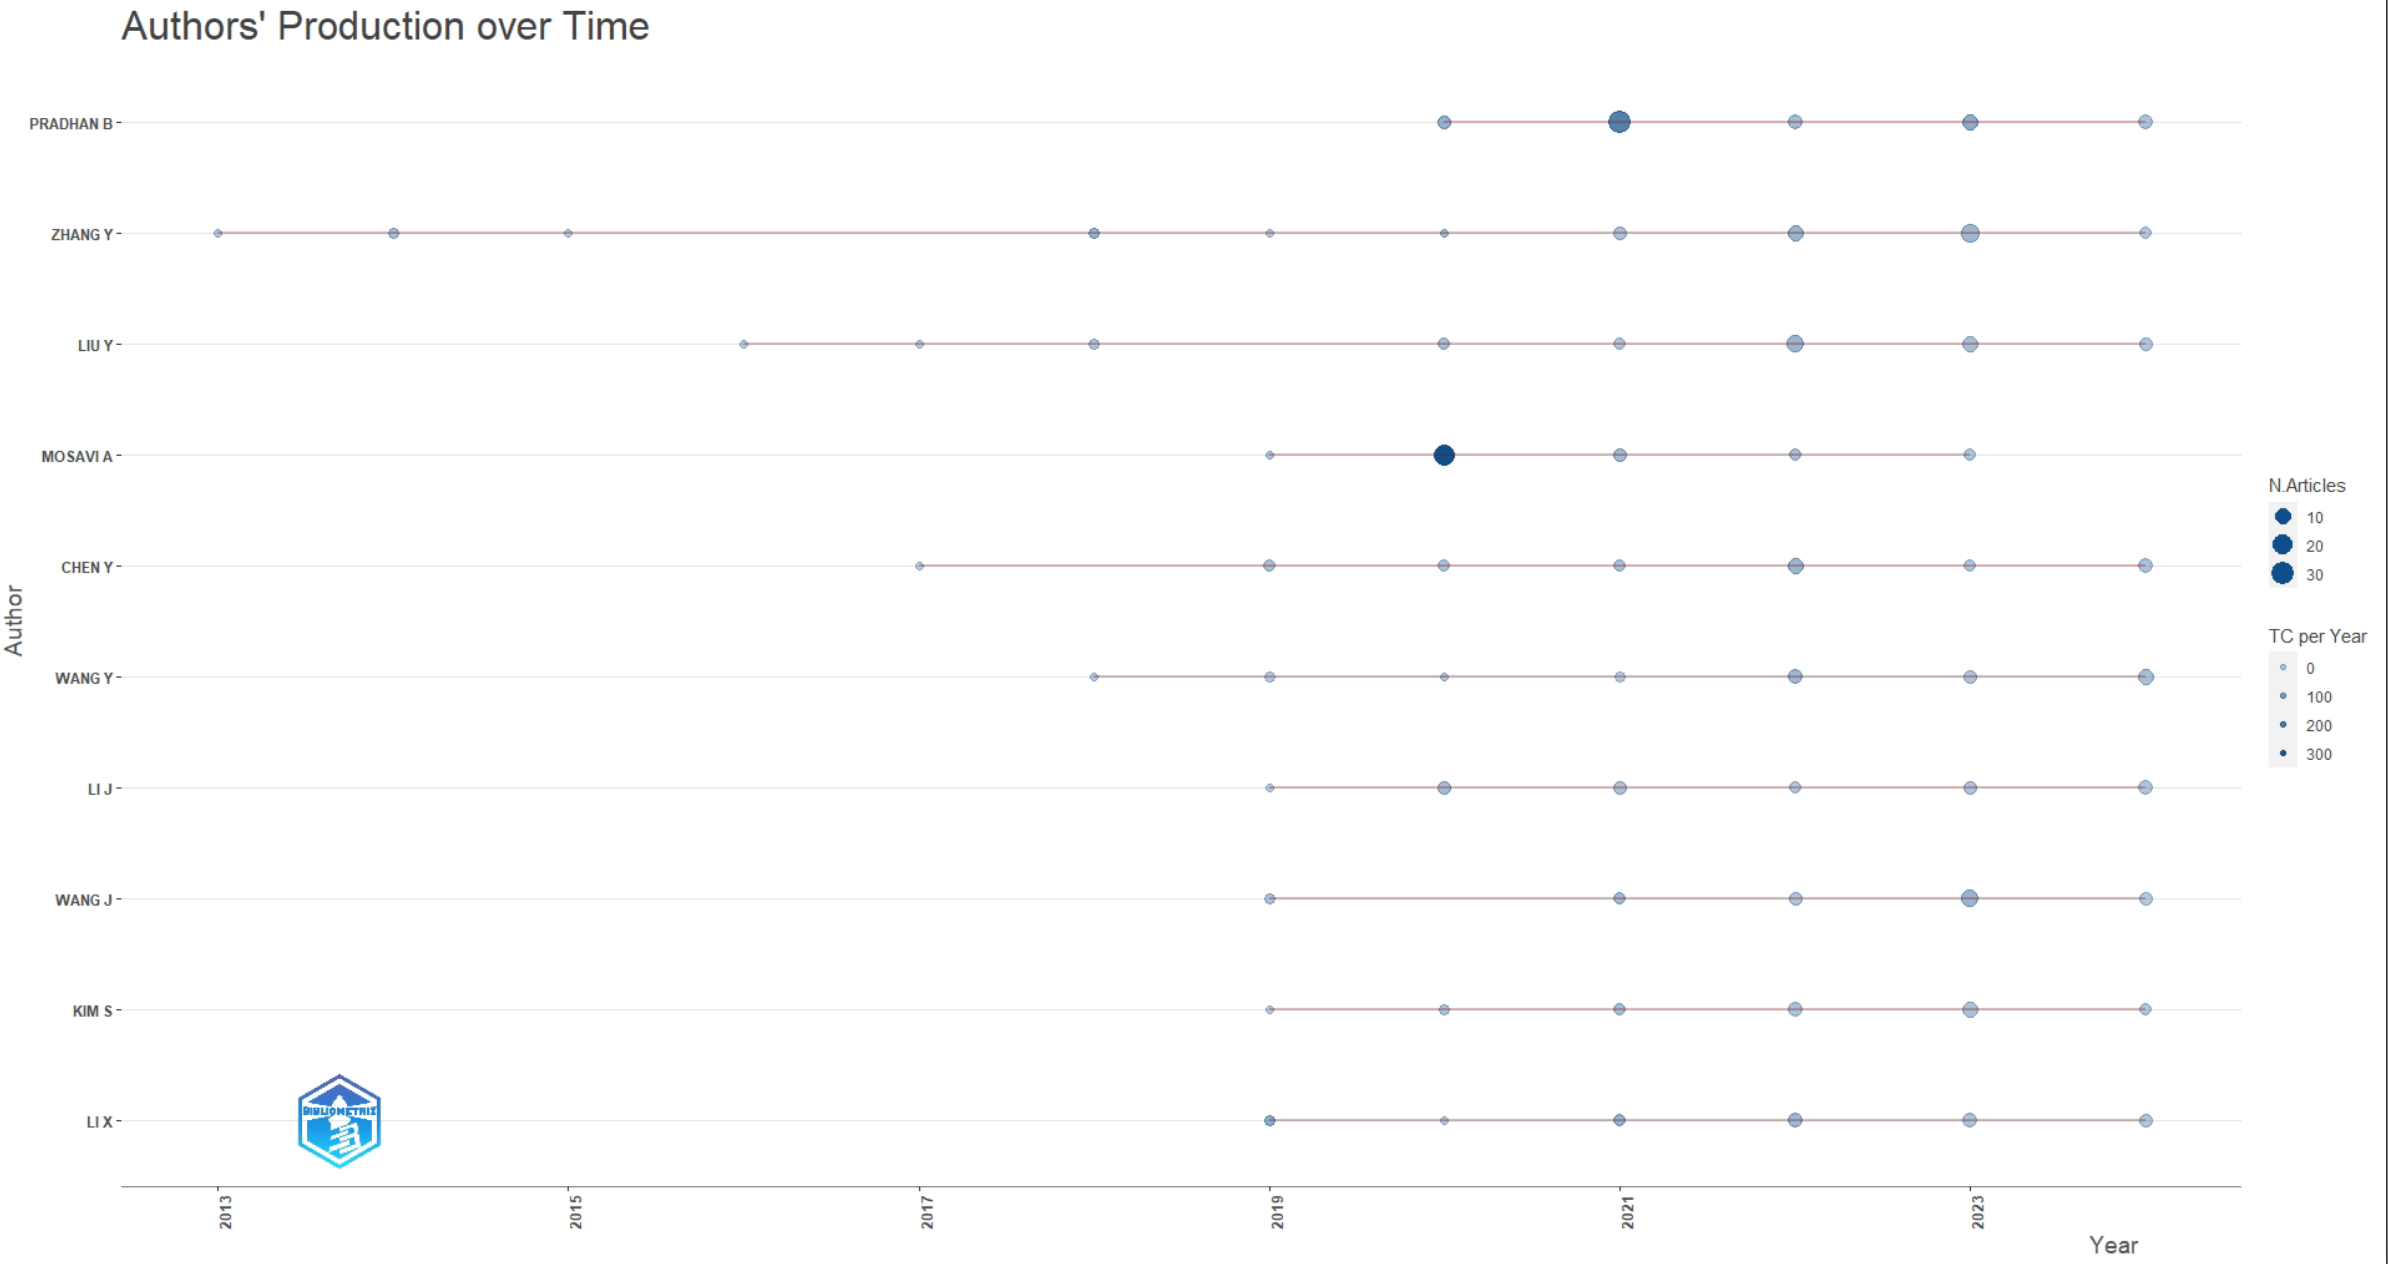

In [73]:
from IPython.display import Image
Image('authors_productivity.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



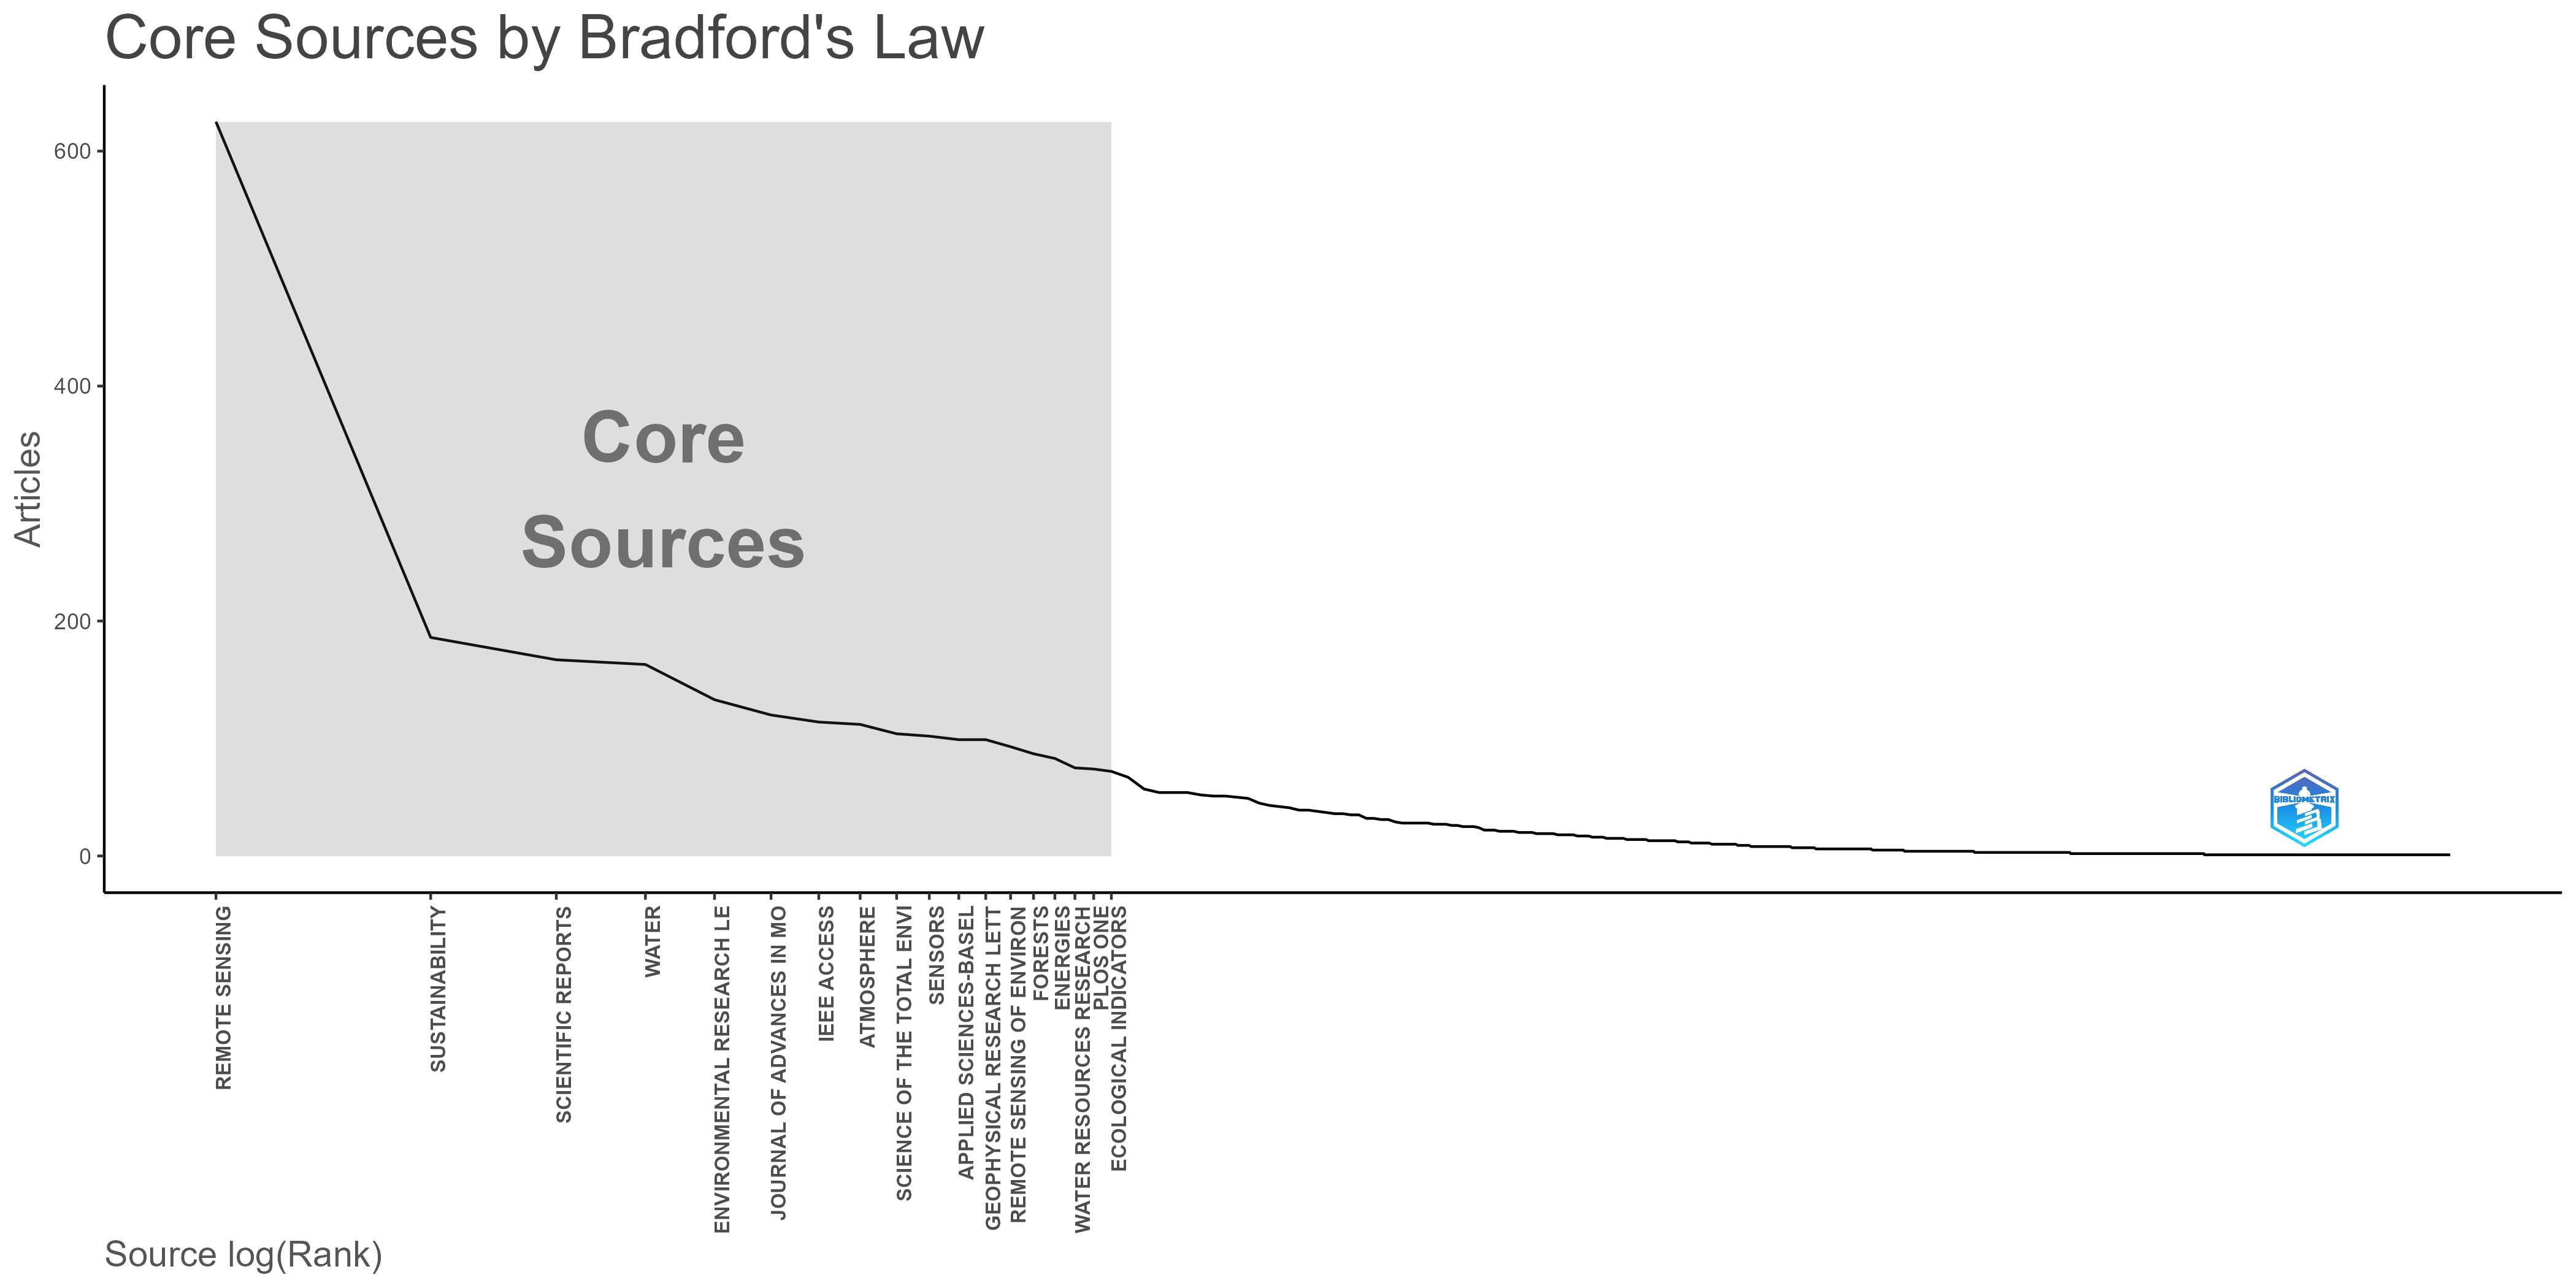

In [74]:
Image('BradfordLaws.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



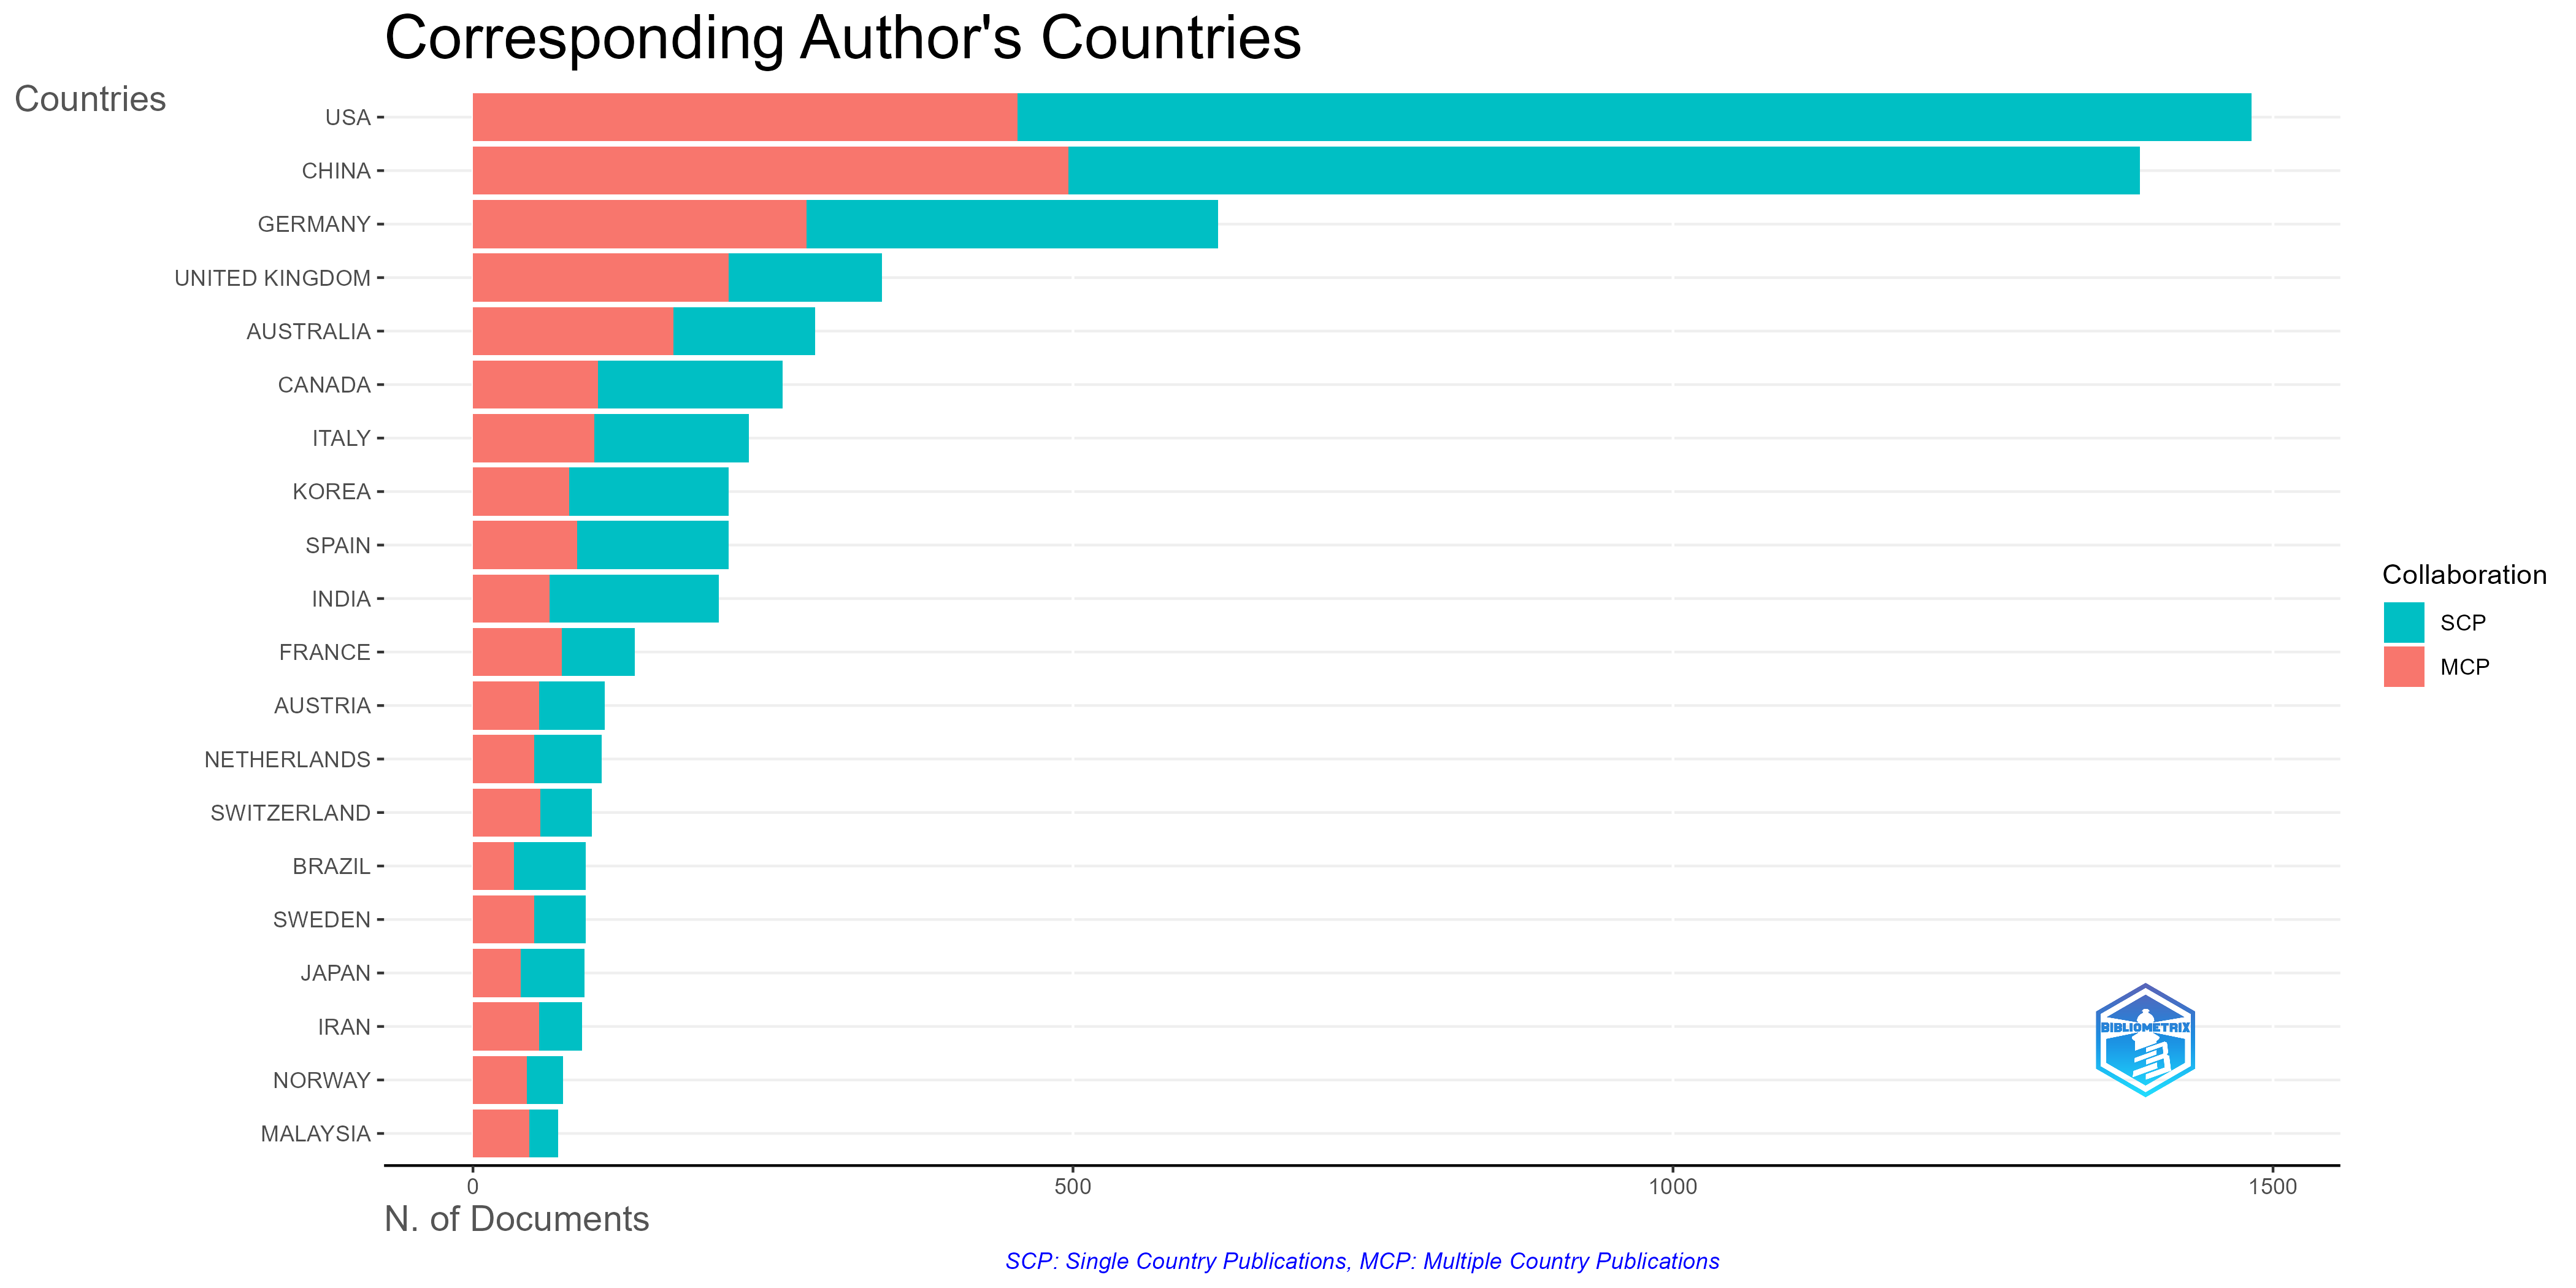

In [75]:
Image("MostRelevantCountries.png")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



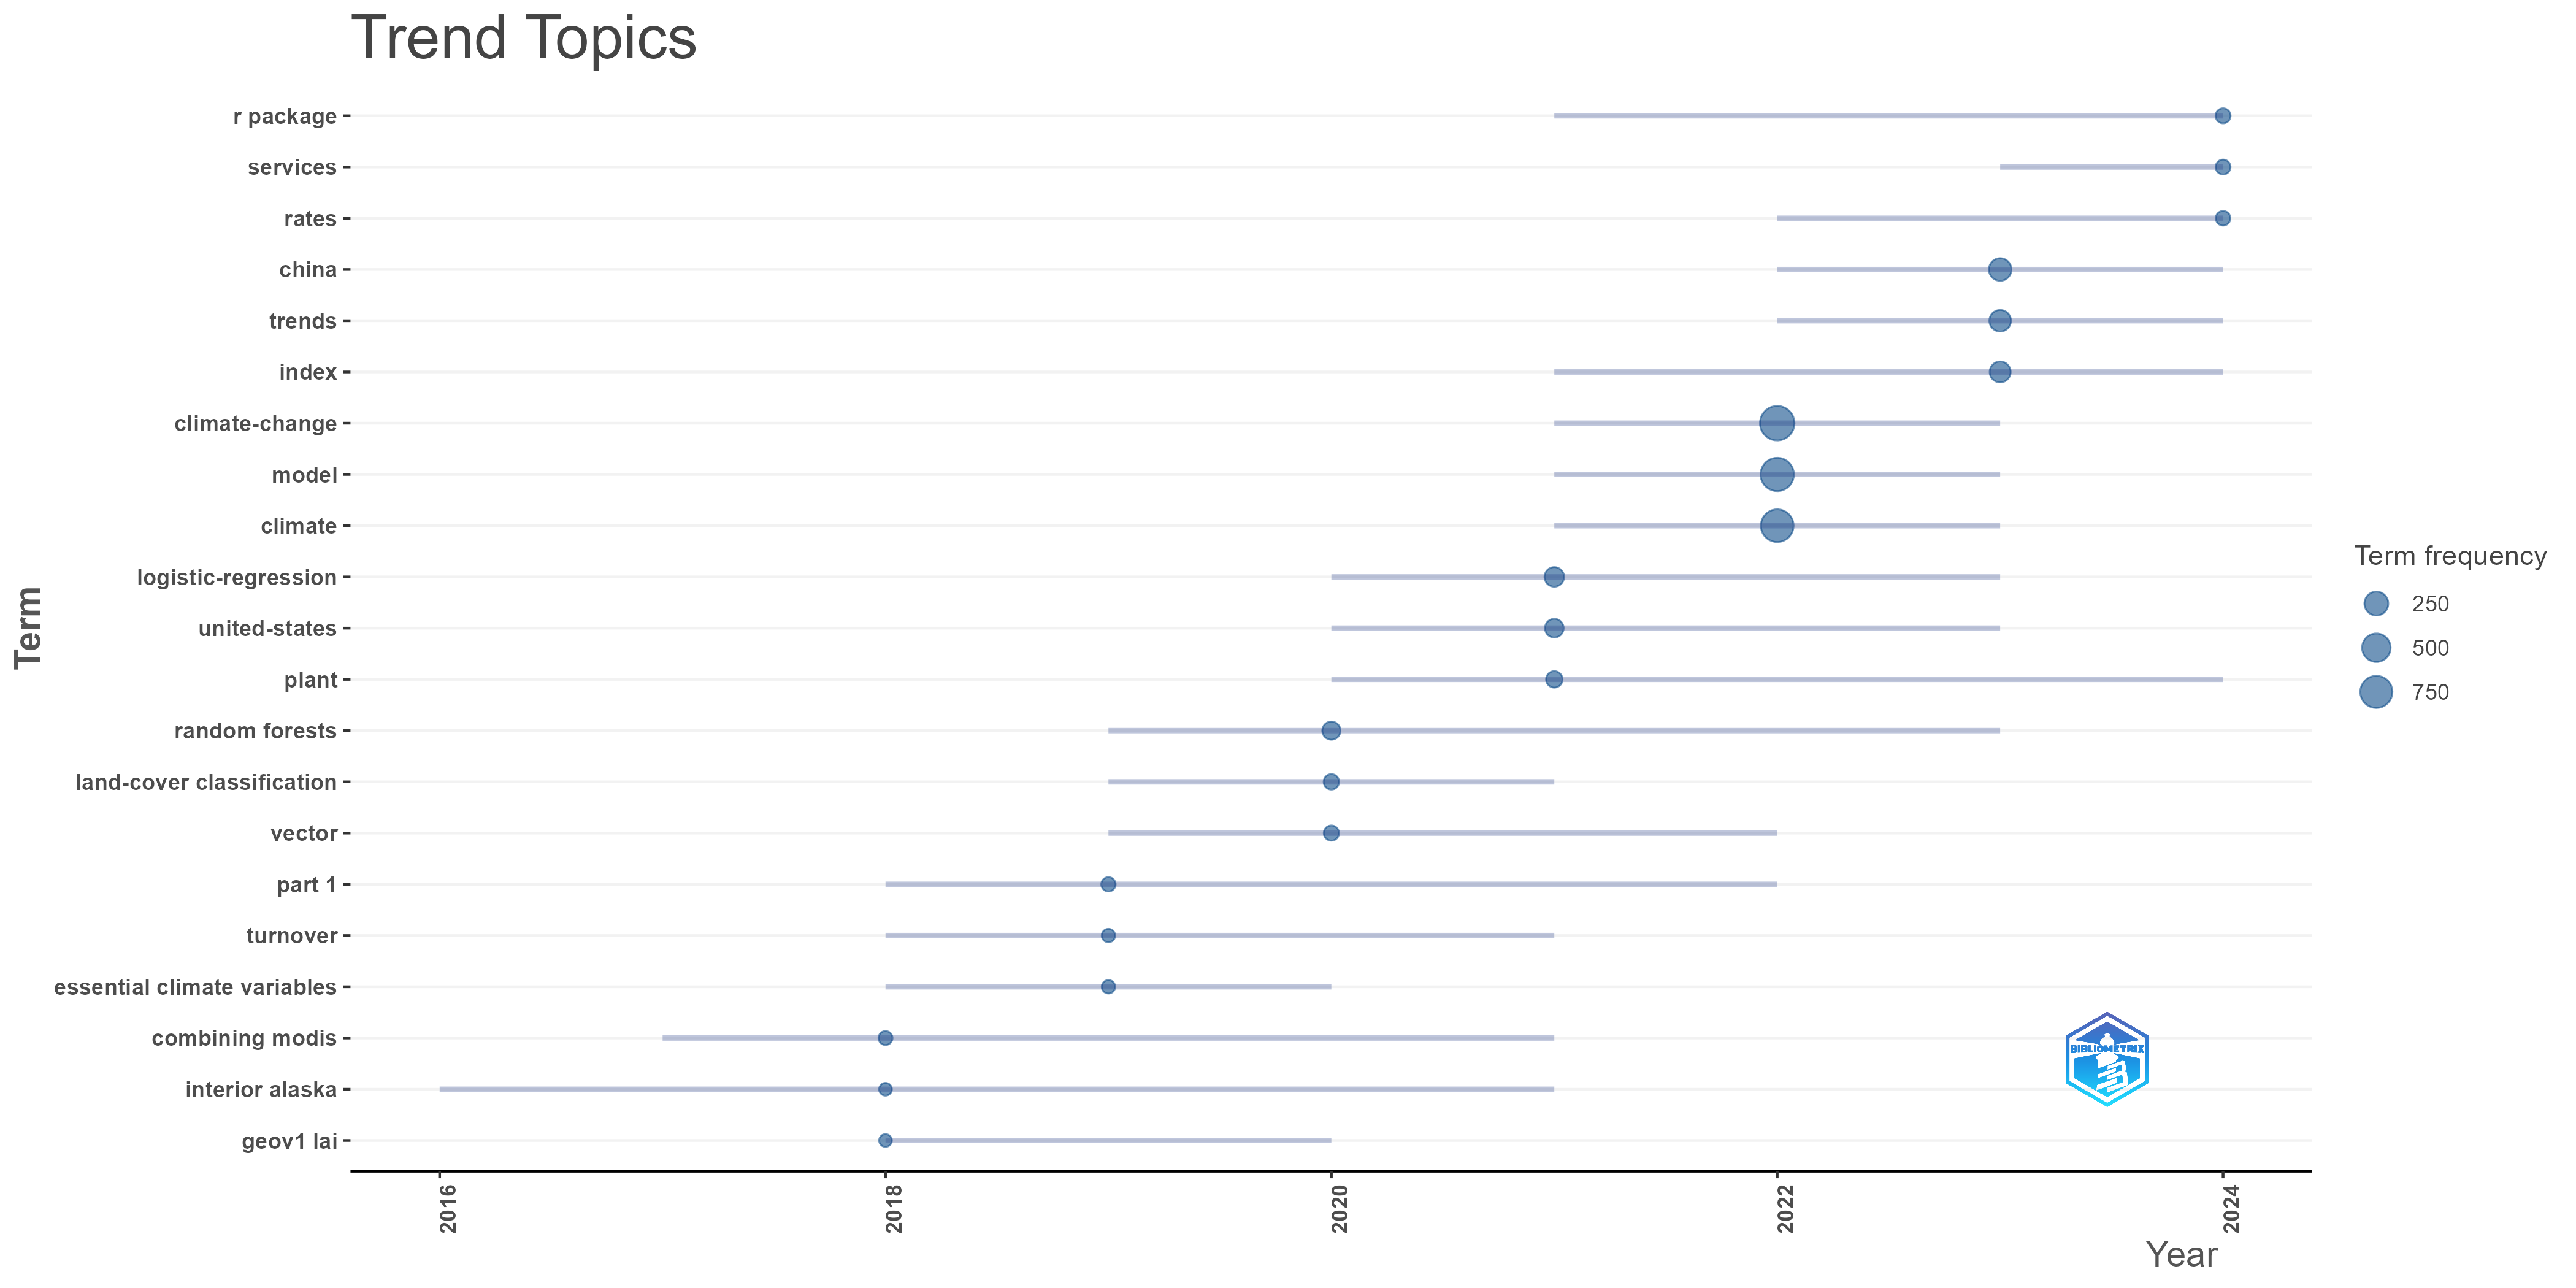

In [77]:
Image("TrendTopics.png")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



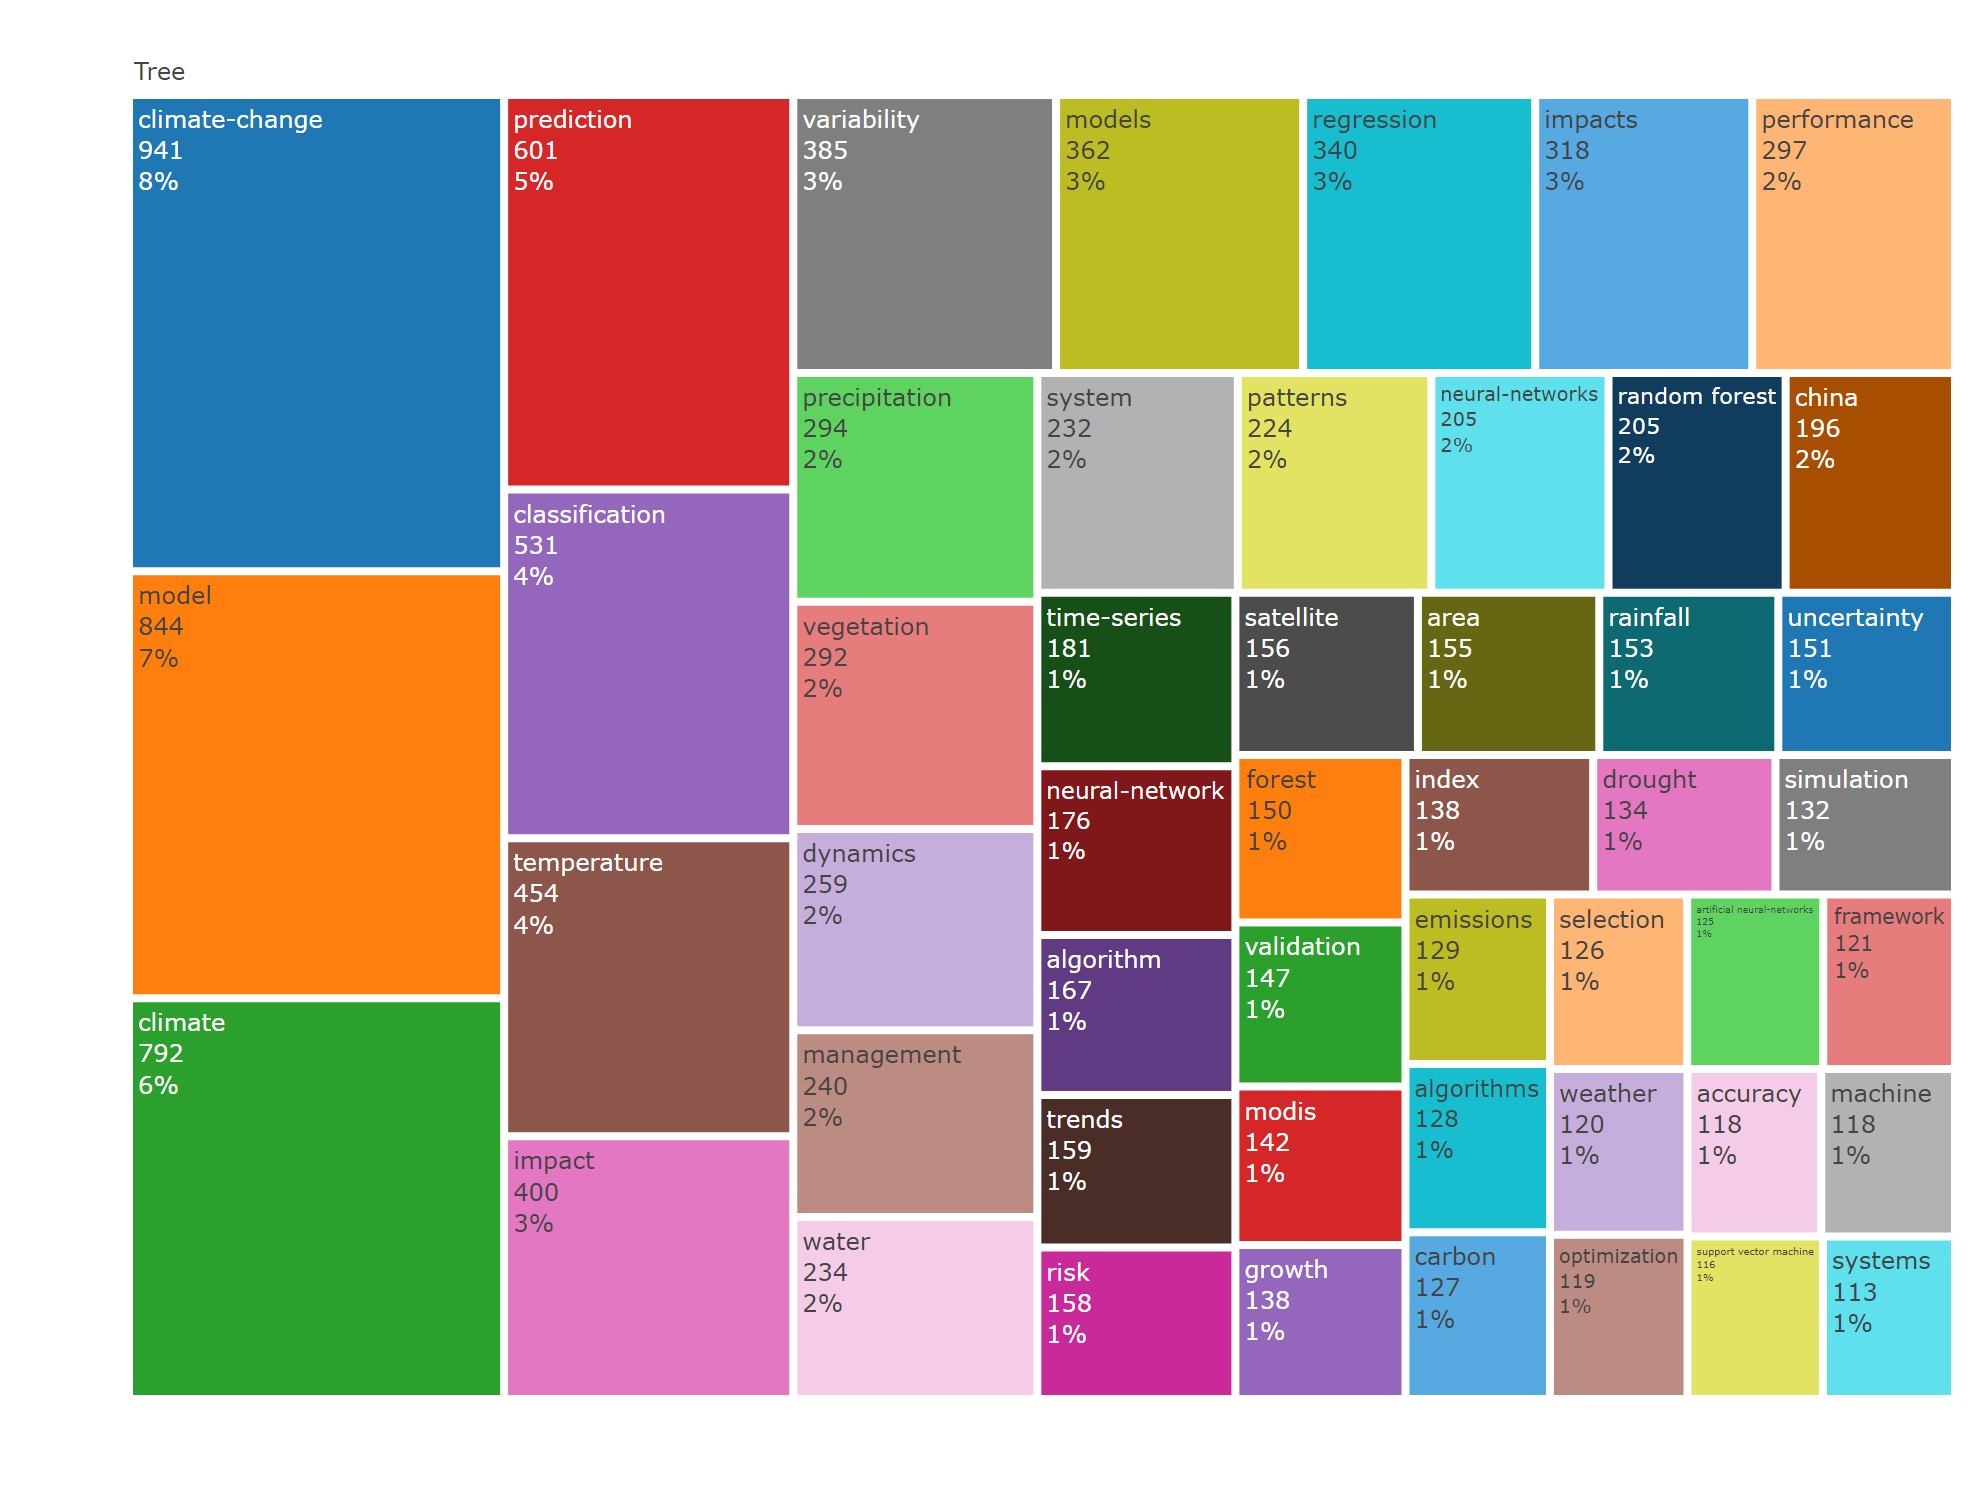

In [78]:
Image("TreeMap.png")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



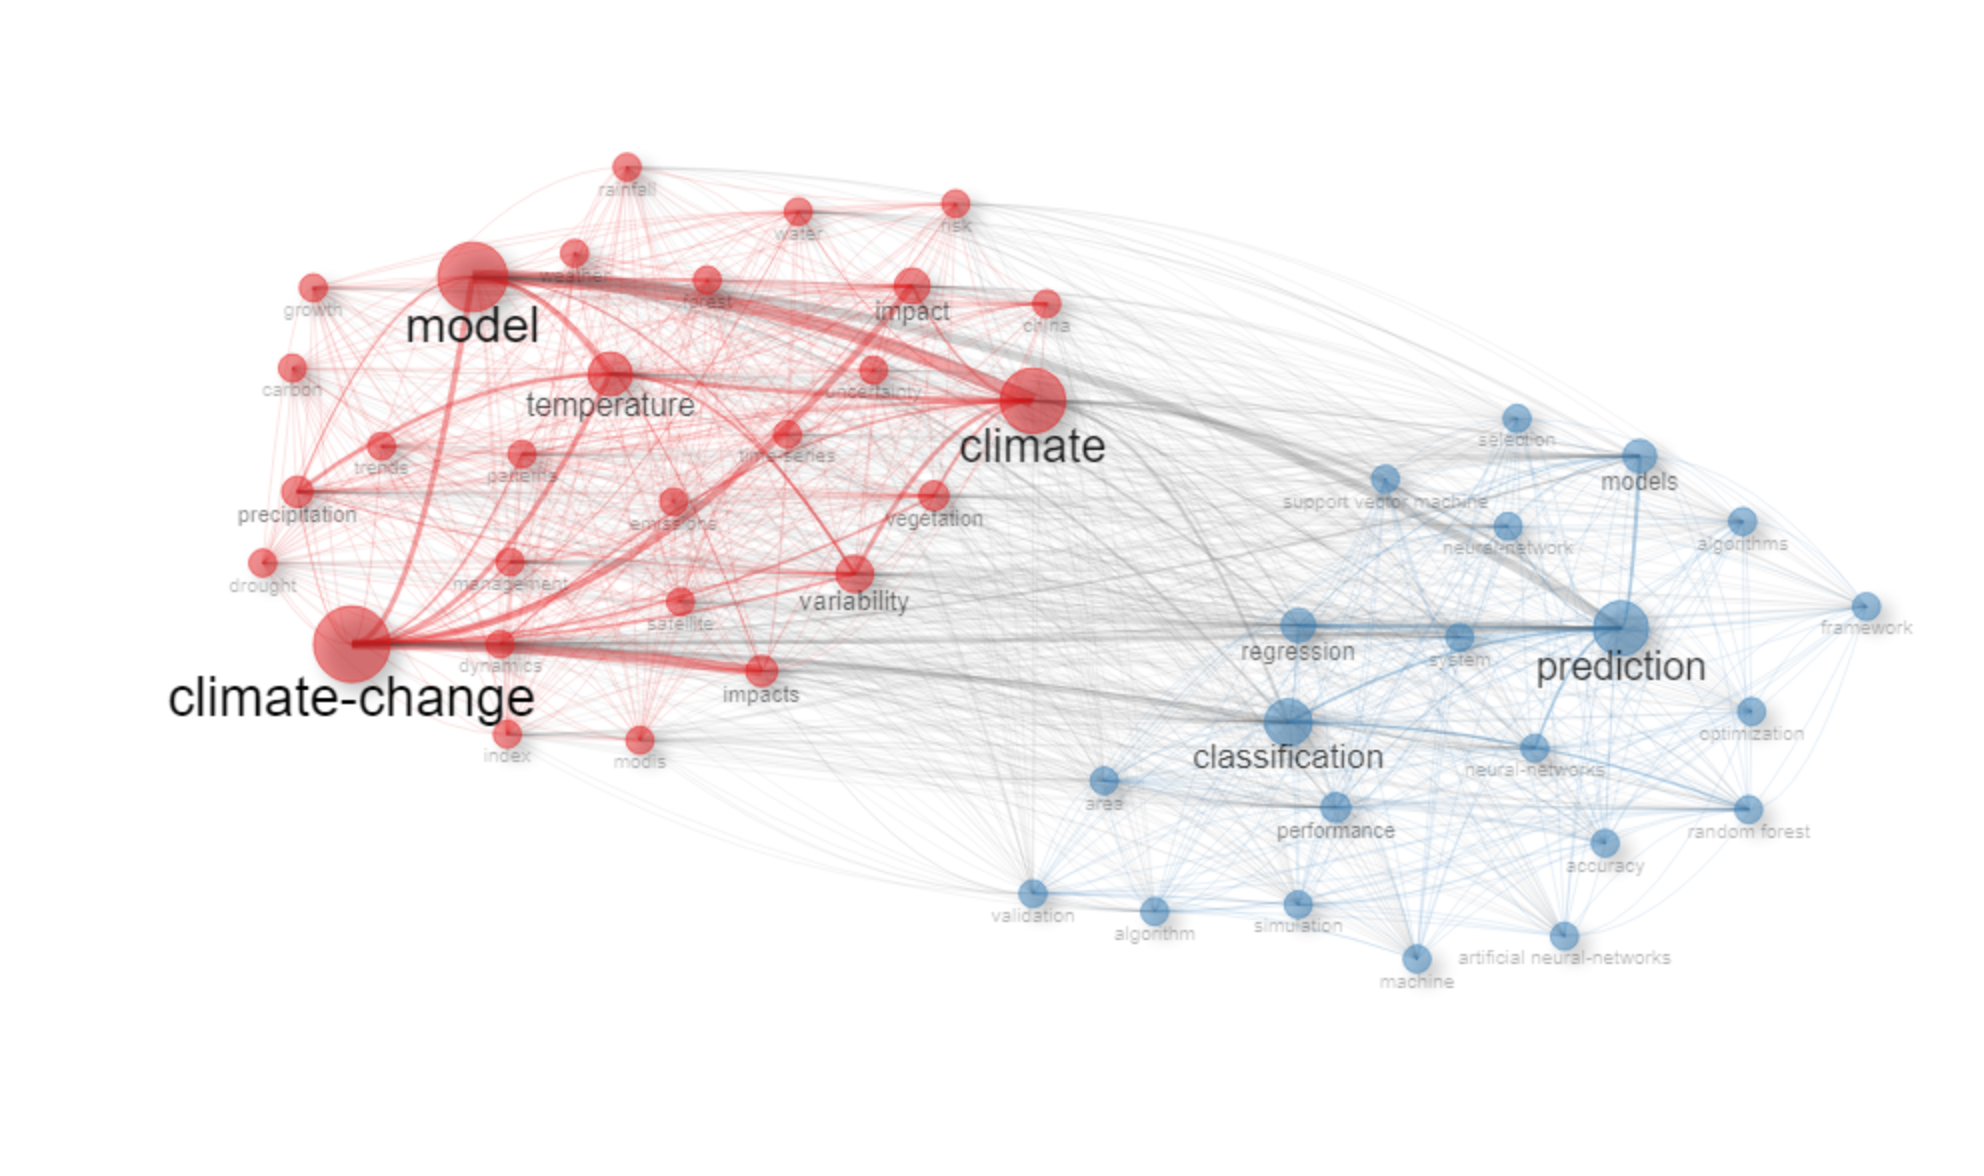

In [81]:
Image("Fig6_Co_occurrenceNetwork.png")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



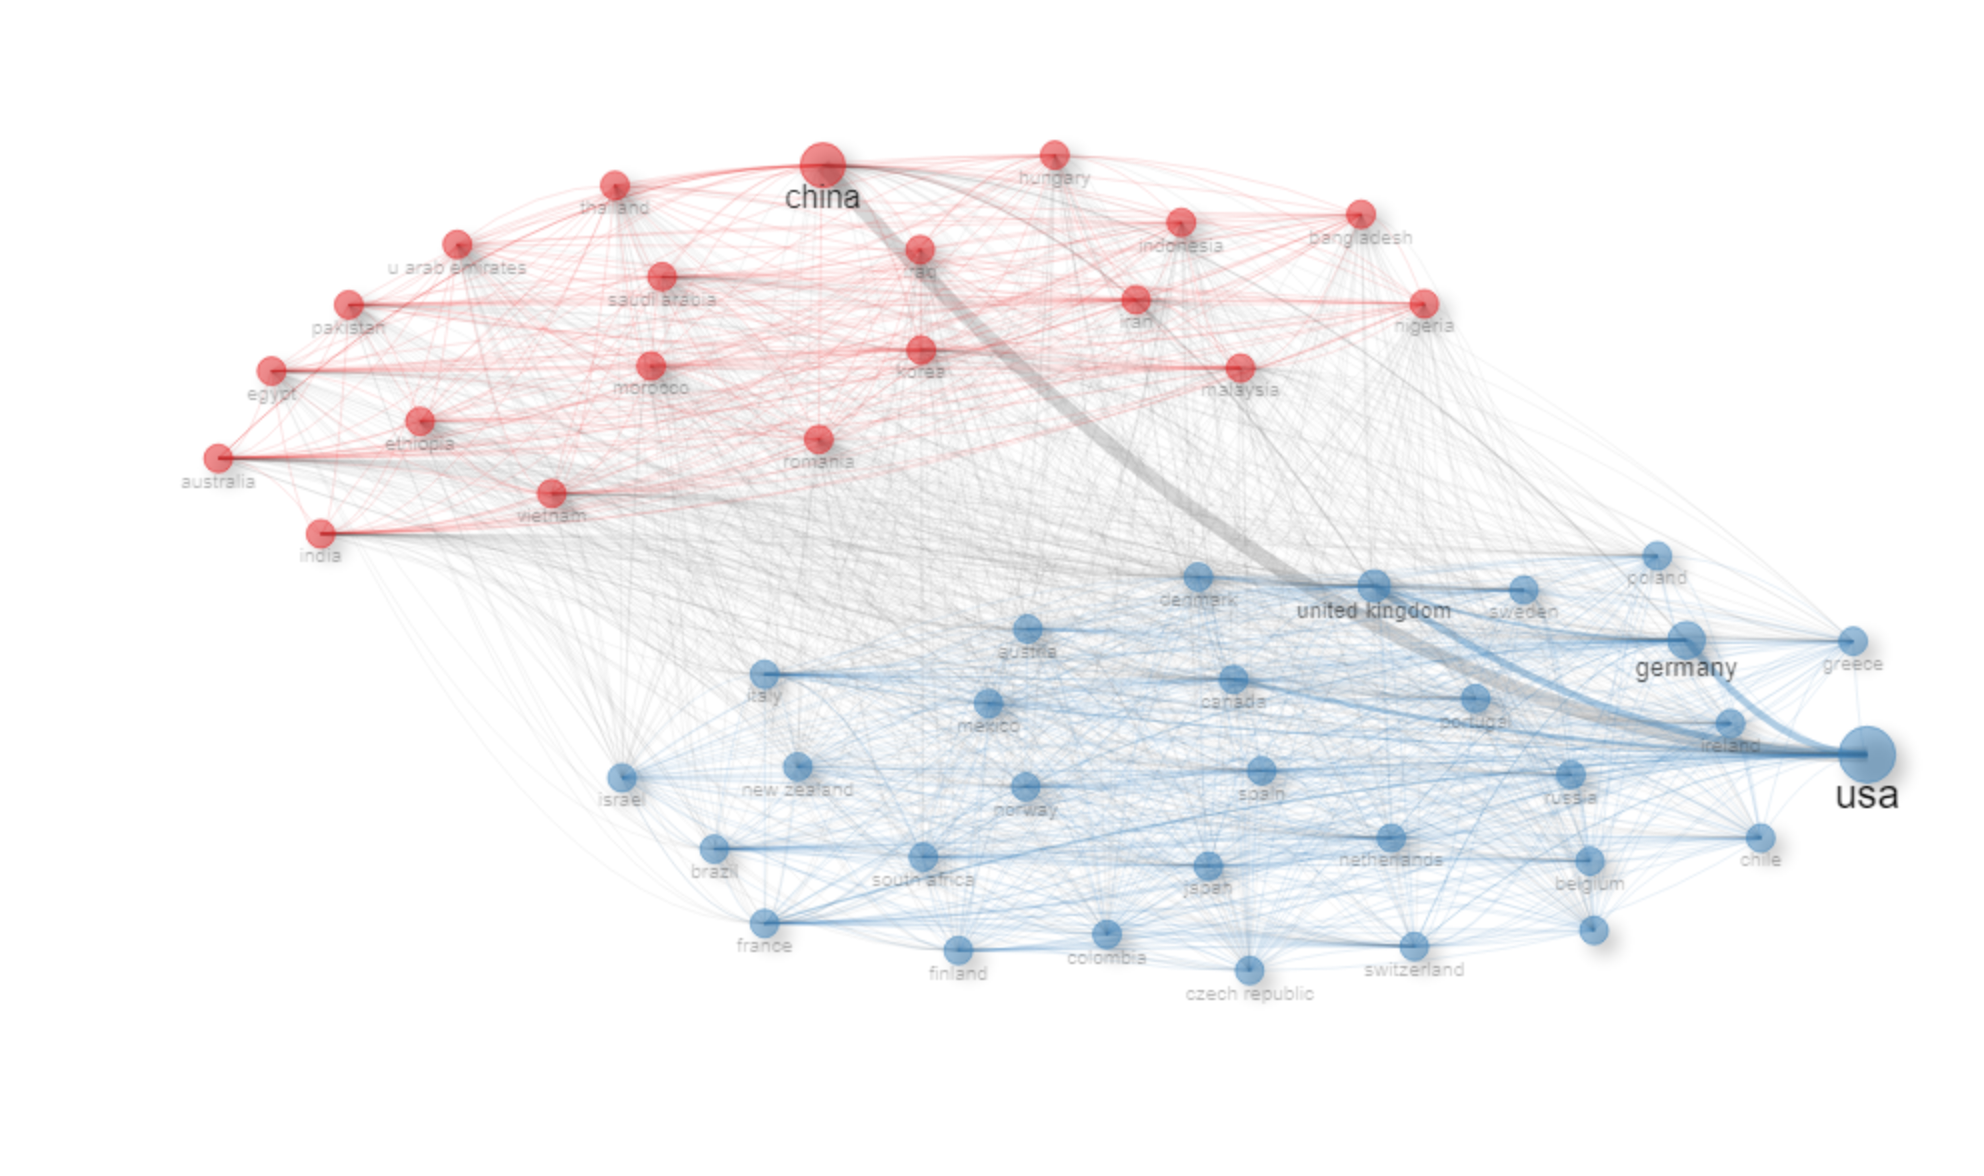

In [82]:
Image("Collaboration_Network.png")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



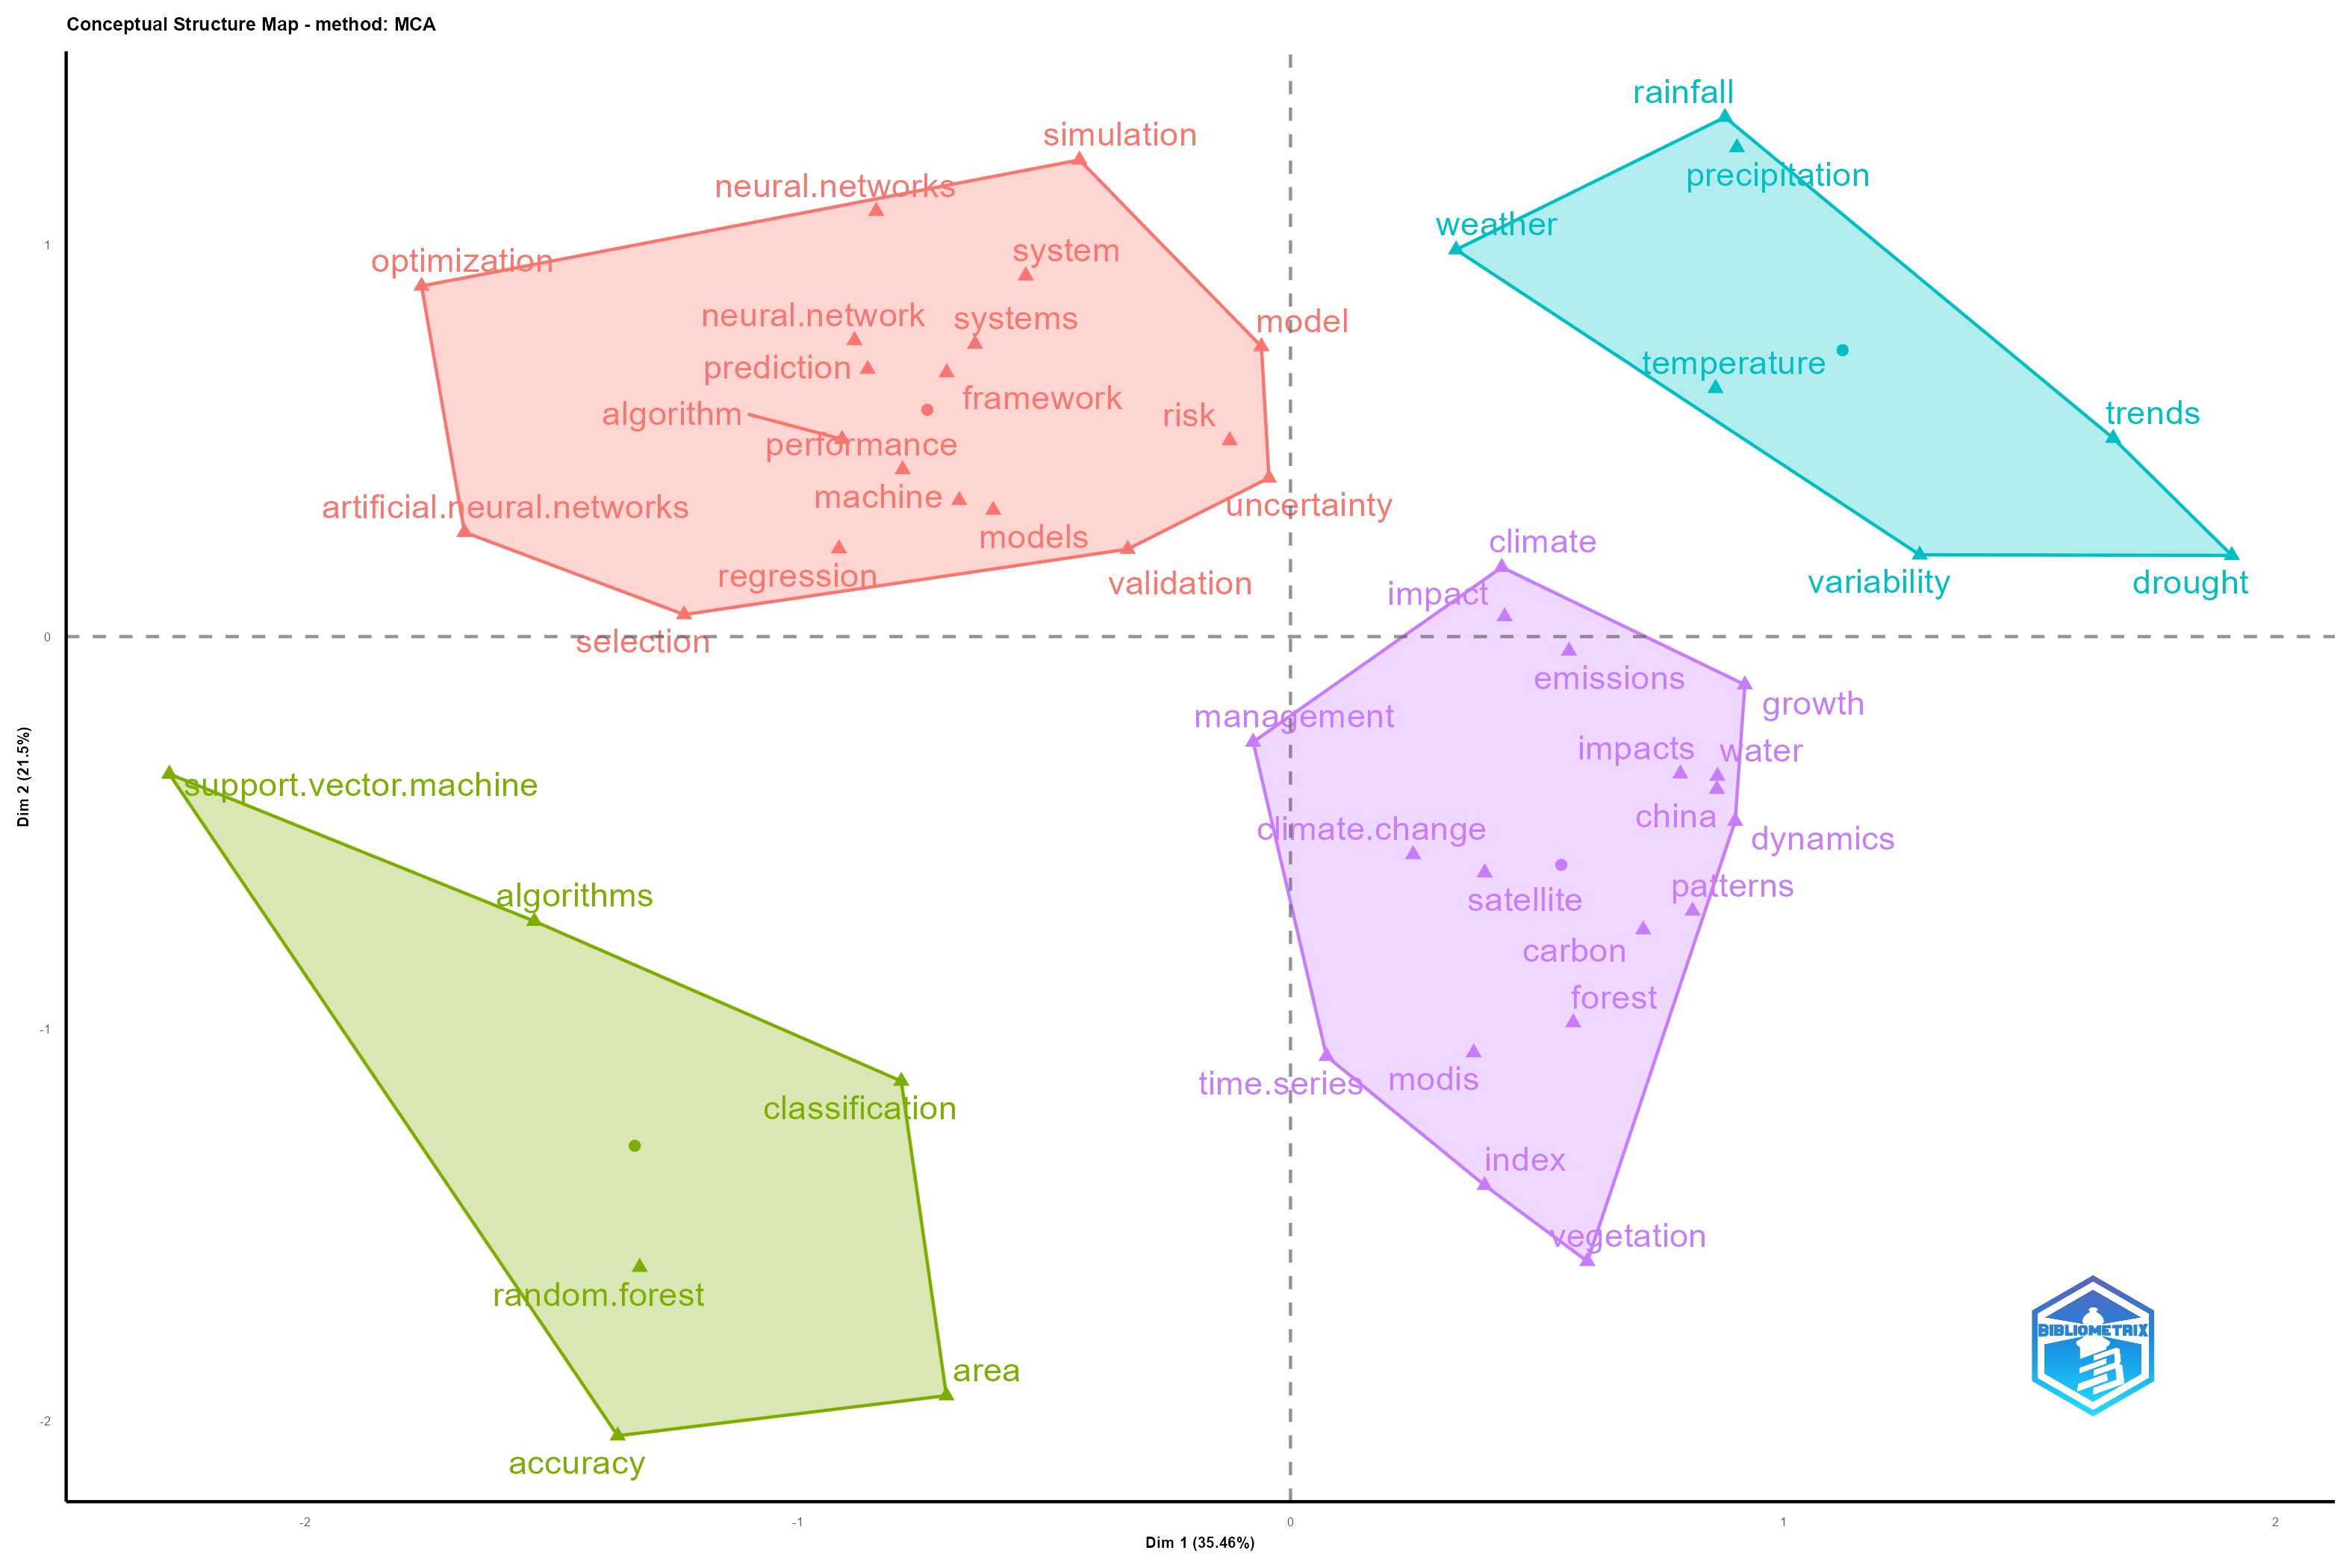

In [83]:
Image("Fig10_FactorialMap.png")

## 2. Publications and citations per year


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


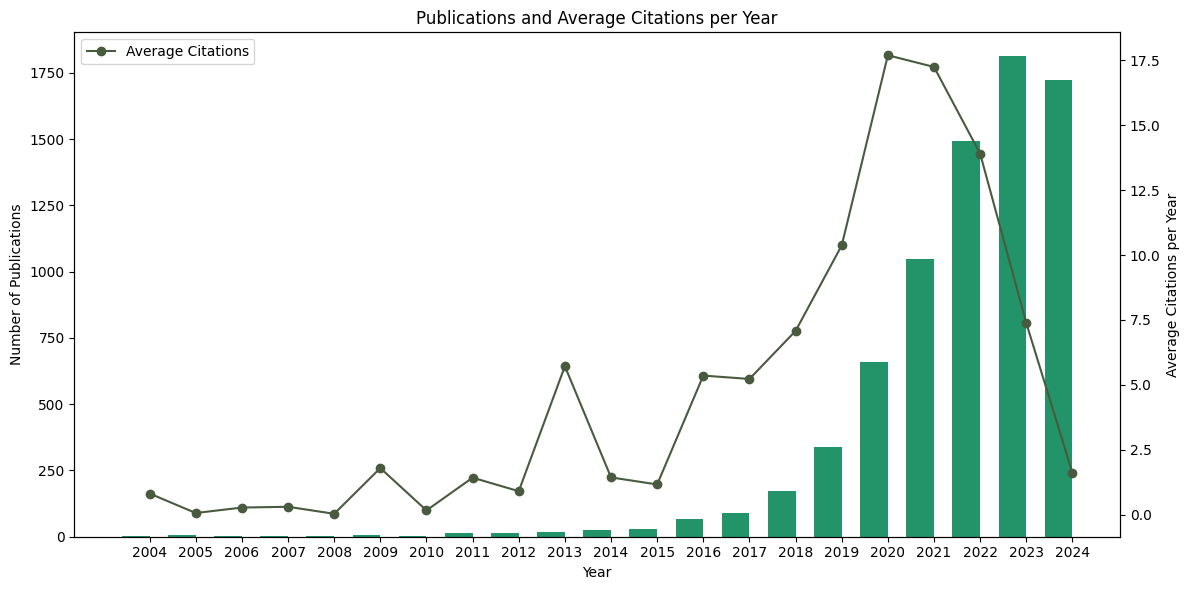

In [39]:
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

width = 0.6

publications_by_year = climate['Publication Year'].value_counts().sort_index()

ax1.bar(publications_by_year.index - width / 2, publications_by_year.values, width=width, color='#23946a', label='Publications')
ax2.plot(table_1['Average citations per Year'].index, table_1['Average citations per Year'].values, color='#485B3E', marker='o', label='Average Citations')


ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Publications')
ax2.set_ylabel('Average Citations per Year')
plt.xticks(publications_by_year.index, rotation=45, ha='right')
plt.title('Publications and Average Citations per Year')
plt.tight_layout()
plt.legend(loc='upper left')

plt.show()

### 3. Research areas

In [49]:
research_areas_complete = climate['Research Areas'].str.split('; ').explode()
research_areas_complete = research_areas_complete.fillna(0)
top_20_research_areas = research_areas_complete.value_counts().nlargest(20)

def format_label(label):
    max_length = 20  # For large text to show on multiple lines
    words = label.split(' ')
    lines = []
    current_line = ""

    for word in words:
        if len(current_line) + len(word) + 1 <= max_length:
            current_line += word + " "
        else:
            lines.append(current_line.strip())
            current_line = word + " "
    lines.append(current_line.strip())

    return "<br>".join(lines)

formatted_labels = [format_label(label) for label in top_20_research_areas.index]

fig = px.treemap(
    names=formatted_labels,
    path=[formatted_labels],
    values=top_20_research_areas.values,
    title='Top 20 Research Areas by number of Publications',
    color=top_20_research_areas.values,
    color_continuous_scale='BrBG'
)

fig.update_traces(root_color="lightgrey")
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.update_layout(title_text='Top 20 Research Areas by number of Publications', title_x=0.5)
fig.data[0].texttemplate = "%{label}<br>%{value}<br>%{percentRoot}"
fig.update_layout(
    font=dict(
        size=14
    )
)

fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### 4. Web of Science categories

In [43]:
wos_categories_complete = climate['WoS Categories'].str.split('; ').explode()
top_25_wos_categories = wos_categories_complete.value_counts().nlargest(25)
print(top_25_wos_categories)

formatted_labels = [format_label(label) for label in top_25_wos_categories.index]

fig = px.treemap(
    names=formatted_labels,
    path=[formatted_labels],
    values=top_25_wos_categories.values,
    title='Top 25 WoS Categories by number of Publications',
    color=top_25_wos_categories.values,
    color_continuous_scale='delta'
)
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.data[0].texttemplate = "%{label}<br>%{value}"
fig.show()

WoS Categories
ENVIRONMENTAL SCIENCES                              2454
GEOSCIENCES, MULTIDISCIPLINARY                      1429
METEOROLOGY & ATMOSPHERIC SCIENCES                  1105
REMOTE SENSING                                      1048
IMAGING SCIENCE & PHOTOGRAPHIC TECHNOLOGY            866
WATER RESOURCES                                      748
MULTIDISCIPLINARY SCIENCES                           584
ECOLOGY                                              433
ENGINEERING, ELECTRICAL & ELECTRONIC                 395
ENVIRONMENTAL STUDIES                                345
GREEN & SUSTAINABLE SCIENCE & TECHNOLOGY             279
ENERGY & FUELS                                       277
COMPUTER SCIENCE, INFORMATION SYSTEMS                268
COMPUTER SCIENCE, INTERDISCIPLINARY APPLICATIONS     221
GEOGRAPHY, PHYSICAL                                  220
FORESTRY                                             220
AGRONOMY                                             194
BIODIVERSITY CON

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### 5. Publications by Journals

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Source Title
REMOTE SENSING                                                           625
SUSTAINABILITY                                                           186
SCIENTIFIC REPORTS                                                       167
WATER                                                                    163
ENVIRONMENTAL RESEARCH LETTERS                                           133
JOURNAL OF ADVANCES IN MODELING EARTH SYSTEMS                            120
IEEE ACCESS                                                              114
ATMOSPHERE                                                               112
SCIENCE OF THE TOTAL ENVIRONMENT                                         104
SENSORS                                                                  102
APPLIED SCIENCES-BASEL                                                    99
GEOPHYSICAL RESEARCH LETTERS                                              99
REMOTE SENSING OF ENVIRONMENT                                  

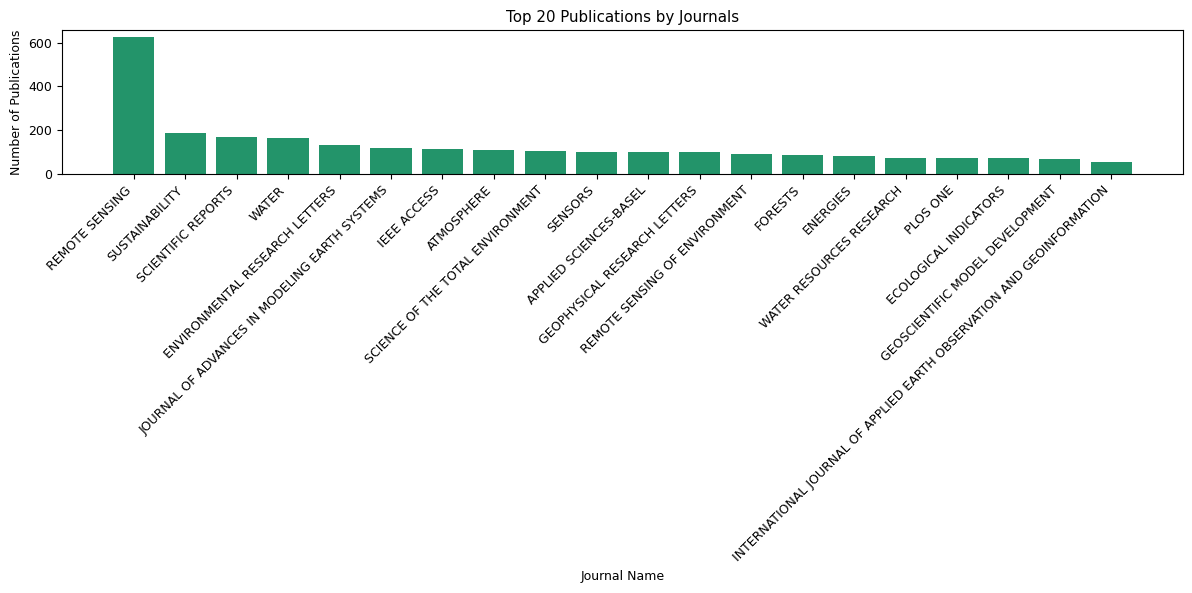

In [44]:
top_20_journals = climate['Source Title'].value_counts().nlargest(20)

print(top_20_journals)

plt.rcParams.update({'font.size': 9})
plt.figure(figsize=(12, 6))
plt.bar(top_20_journals.index, top_20_journals.values, color='#23946a')
plt.xlabel('Journal Name')
plt.ylabel('Number of Publications')
plt.title('Top 20 Publications by Journals')
plt.xticks(top_20_journals.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Source Title
REMOTE SENSING                                                           625
SUSTAINABILITY                                                           186
SCIENTIFIC REPORTS                                                       167
WATER                                                                    163
ENVIRONMENTAL RESEARCH LETTERS                                           133
JOURNAL OF ADVANCES IN MODELING EARTH SYSTEMS                            120
IEEE ACCESS                                                              114
ATMOSPHERE                                                               112
SCIENCE OF THE TOTAL ENVIRONMENT                                         104
SENSORS                                                                  102
APPLIED SCIENCES-BASEL                                                    99
GEOPHYSICAL RESEARCH LETTERS                                              99
REMOTE SENSING OF ENVIRONMENT                                  

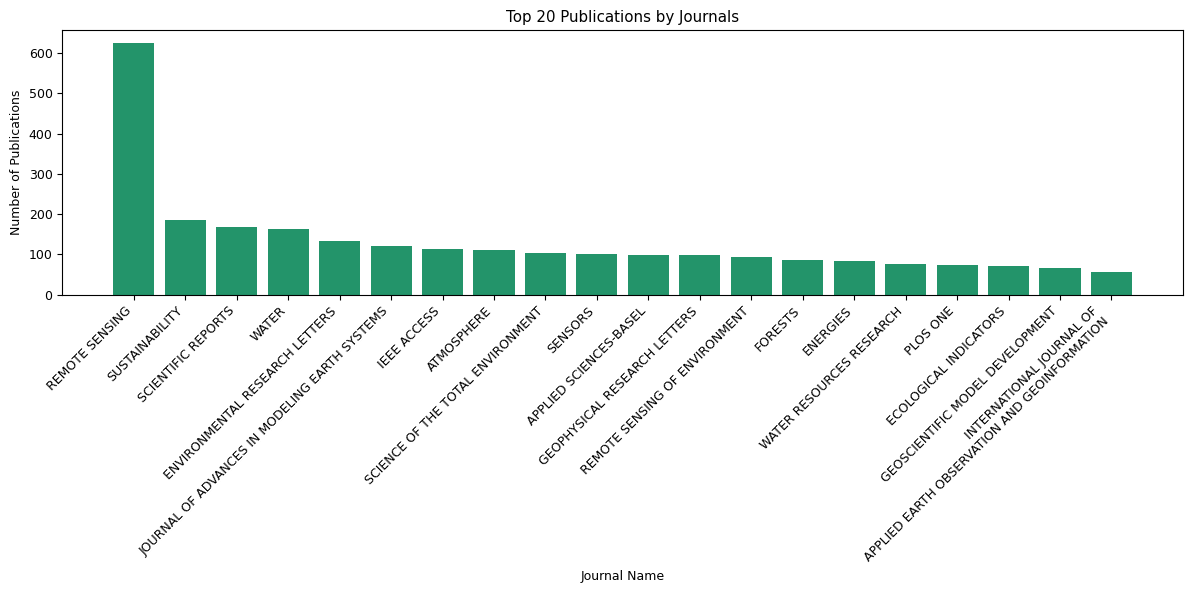

In [48]:
top_20_journals = climate['Source Title'].value_counts().nlargest(20)

print(top_20_journals)

plt.rcParams.update({'font.size': 9})
plt.figure(figsize=(12, 6))

def format_label_plot(label):
    max_length = 56  # Format journal name if it is too big
    if len(label) > max_length:
        words = label.split(' ')
        first_line = ""
        second_line = ""

        for word in words:
            if len(first_line) + len(word) + 1 <= max_length // 2:
                first_line += word + " "
            else:
                second_line += word + " "

        return first_line.strip() + '\n' + second_line.strip()
    return label

formatted_labels = [format_label_plot(label) for label in top_20_journals.index]

plt.bar(formatted_labels, top_20_journals.values, color='#23946a')
plt.xlabel('Journal Name')
plt.ylabel('Number of Publications')
plt.title('Top 20 Publications by Journals')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 6. Publications by Affiliations

In [50]:
affiliations_complete = climate['Affiliations'].str.split('; ').explode()
top_20_affiliations = affiliations_complete.value_counts().nlargest(20)
print(top_20_affiliations)

formatted_labels = [format_label(label) for label in top_20_affiliations.index]

fig = px.treemap(
    names=formatted_labels,
    path=[formatted_labels],
    values=top_20_affiliations.values,
    title='Top 20 Affiliations by number of Publications',
    color=top_20_affiliations.values,
    color_continuous_scale='Blues'
)
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.data[0].texttemplate = "%{label}<br>%{value}"
fig.show()

Affiliations
CHINESE ACADEMY OF SCIENCES                               854
UNIVERSITY OF CALIFORNIA SYSTEM                           446
HELMHOLTZ ASSOCIATION                                     385
UNITED STATES DEPARTMENT OF ENERGY (DOE)                  325
CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE (CNRS)       296
SWISS FEDERAL INSTITUTES OF TECHNOLOGY DOMAIN             244
UNIVERSITY OF CHINESE ACADEMY OF SCIENCES, CAS            229
NATIONAL OCEANIC ATMOSPHERIC ADMIN (NOAA) - USA           200
EGYPTIAN KNOWLEDGE BANK (EKB)                             195
UNITED STATES DEPARTMENT OF THE INTERIOR                  187
NATIONAL AERONAUTICS & SPACE ADMINISTRATION (NASA)        186
UNITED STATES DEPARTMENT OF AGRICULTURE (USDA)            178
UNIVERSITY SYSTEM OF MARYLAND                             168
UNITED STATES GEOLOGICAL SURVEY                           163
BEIJING NORMAL UNIVERSITY                                 160
NANJING UNIVERSITY OF INFORMATION SCIENCE & TECHNOLOGY   

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### 7. Countries

In [51]:
def deduplicate_countries(country_list):
    new_list = country_list.split(';')
    new_list = [i for n, i in enumerate(new_list) if i not in new_list[:n]]
    return ';'.join(new_list)

bibliometrics['AU_CO_PROC'] = bibliometrics['AU_CO'].fillna("").apply(deduplicate_countries)

countries_complete = bibliometrics['AU_CO_PROC'].str.split(';').explode()
top_30_countries = countries_complete.value_counts().nlargest(30)

fig = px.treemap(
    names=top_30_countries.index,
    path=[top_30_countries.index],
    values=top_30_countries.values,
    title='Top 30 Countries by number of Publications',
    color=top_30_countries.values,
    color_continuous_scale='delta'
)
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.data[0].texttemplate = "%{label}<br>%{value}"
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [53]:
top_50_countries = countries_complete.value_counts().nlargest(50)
df = top_50_countries.reset_index()
df.columns = ['Country', 'Publications']

fig = px.choropleth(
    df,
    locations='Country',
    locationmode='country names',
    color='Publications',
    hover_name='Country',
    color_continuous_scale='Greens',
    title='Number of Publications by top 50 Countries'
)
fig.update_layout(title_text='Number of Publications by top 50 Countries', title_x=0.5)
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [54]:
print(top_30_countries.values)
print(top_30_countries.index)

[2262 1711 1040  751  509  476  425  408  395  368  340  307  274  249
  236  225  208  197  196  186  173  131  130  125  115  113  111  105
  101  101]
Index(['USA', 'CHINA', 'GERMANY', 'UNITED KINGDOM', 'AUSTRALIA', 'CANADA',
       'ITALY', 'SPAIN', 'INDIA', 'FRANCE', 'NETHERLANDS', 'KOREA',
       'SWITZERLAND', 'SWEDEN', 'IRAN', 'SAUDI ARABIA', 'JAPAN', 'AUSTRIA',
       'MALAYSIA', 'NORWAY', 'BRAZIL', 'DENMARK', 'FINLAND', 'VIETNAM',
       'BELGIUM', 'SOUTH AFRICA', 'PORTUGAL', 'POLAND', 'GREECE', 'EGYPT'],
      dtype='object', name='AU_CO_PROC')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### 8. Most cited articles - just information

In [55]:
first_five_articles = climate['Times Cited, All Databases'].sort_values(ascending=False).iloc[0:5]
print("Top 5 most cited articles:")
for article in first_five_articles.index:
  print("---")
  print(climate.iloc[article])

Top 5 most cited articles:
---
Publication Type                                                              J
Authors                       DORMANN, CF; ELITH, J; BACHER, S; BUCHMANN, C;...
Author Full Names             DORMANN, CARSTEN F.; ELITH, JANE; BACHER, SVEN...
Article Title                 COLLINEARITY: A REVIEW OF METHODS TO DEAL WITH...
Source Title                                                          ECOGRAPHY
Author Keywords                                                    MISSING DATA
Keywords Plus                 LATENT ROOT REGRESSION; PRINCIPAL COMPONENT RE...
Abstract                      COLLINEARITY REFERS TO THE NON INDEPENDENCE OF...
Addresses                     [DORMANN, CARSTEN F.; GRUBER, BERND; LAUTENBAC...
Affiliations                  HELMHOLTZ ASSOCIATION; HELMHOLTZ CENTER FOR EN...
Reprint Addresses             DORMANN, CF (CORRESPONDING AUTHOR), UFZ HELMHO...
Email Addresses                            CARSTEN.DORMANN@BIOM.UNI-FREIBURG.DE
Times Cit

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### 9. Most used keywords

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Keywords Plus
MODEL                        1206
CLIMATE-CHANGE                941
CLIMATE                       792
PREDICTION                    601
CLASSIFICATION                531
TEMPERATURE                   454
IMPACT                        400
VARIABILITY                   385
NEURAL-NETWORK                381
REGRESSION                    340
IMPACTS                       318
PERFORMANCE                   297
PRECIPITATION                 294
VEGETATION                    292
DYNAMICS                      259
MANAGEMENT                    240
WATER                         234
SYSTEM                        232
PATTERNS                      224
ARTIFICIAL NEURAL-NETWORK     218
Name: count, dtype: int64
Keywords Plus
TENSILE                    1
TWIP                       1
316L                       1
COVER ASSESSMENT           1
BERKOVICH                  1
ORGANIC SULFUR             1
T91                        1
INDENTATION                1
ACCLIMATION                1
AUTOM

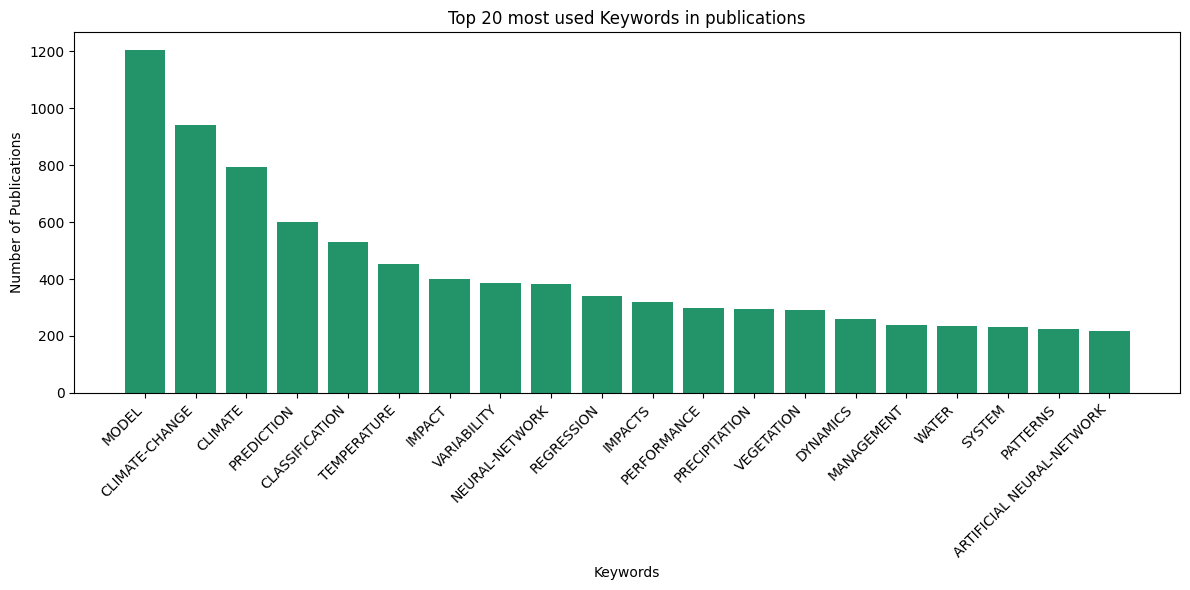

In [10]:
all_keywords = climate['Keywords Plus'].str.split('; ').explode()

all_keywords = all_keywords.replace('MODELS','MODEL')
all_keywords = all_keywords.replace('ARTIFICIAL NEURAL-NETWORKS','ARTIFICIAL NEURAL-NETWORK')
all_keywords = all_keywords.replace('NEURAL-NETWORKS','NEURAL-NETWORK')

top_20_keywords = all_keywords.value_counts().nlargest(20)
least_20_keywords = all_keywords.value_counts().nsmallest(20)
print(top_20_keywords)
print(least_20_keywords)

plt.figure(figsize=(12, 6))
plt.bar(top_20_keywords.index, top_20_keywords.values, color='#23946a')
plt.xlabel('Keywords')
plt.ylabel('Number of Publications')
plt.title('Top 20 most used Keywords in publications')
plt.xticks(top_20_keywords.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


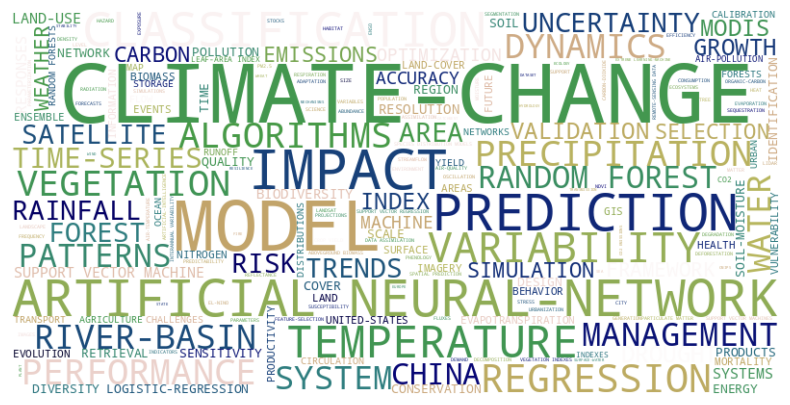

In [11]:
all_keywords = climate['Keywords Plus'].str.split('; ').explode()

all_keywords = all_keywords.replace('MODELS','MODEL')
all_keywords = all_keywords.replace('ARTIFICIAL NEURAL-NETWORKS','ARTIFICIAL NEURAL-NETWORK')
all_keywords = all_keywords.replace('NEURAL-NETWORKS','NEURAL-NETWORK')
all_keywords = all_keywords.replace('NEURAL-NETWORK','ARTIFICIAL NEURAL-NETWORK')
all_keywords = all_keywords.replace('CLIMATE','CLIMATE-CHANGE')
all_keywords = all_keywords.replace('IMPACTS','IMPACT')
all_keywords = all_keywords.replace('RIVER','RIVER-BASIN')
all_keywords = all_keywords.replace('BASIN','RIVER-BASIN')
all_keywords = all_keywords.replace('ALGORITHM','ALGORITHMS')

top_20_keywords = all_keywords.value_counts().nlargest(20)

frequencies = all_keywords.value_counts()
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap="gist_earth_r").generate_from_frequencies(frequencies)

# WordCloud - different runs of the same code will show different results; idea is the same, but colors and position is different
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 10. Pairs of Keywords Plus

In [12]:
climate['Keywords Plus new'] = climate['Keywords Plus']

climate['Keywords Plus new'] = climate['Keywords Plus new'].str.replace('MODELS','MODEL')
climate['Keywords Plus new'] = climate['Keywords Plus new'].str.replace('NEURAL-NETWORKS','NEURAL-NETWORK')
climate['Keywords Plus new'] = climate['Keywords Plus new'].str.replace('NEURAL-NETWORK','ARTIFICIAL NEURAL-NETWORKS')
climate['Keywords Plus new'] = climate['Keywords Plus new'].str.replace('ARTIFICIAL NEURAL-NETWORKS','ARTIFICIAL NEURAL-NETWORK')
climate['Keywords Plus new'] = climate['Keywords Plus new'].str.replace('ARTIFICIAL ARTIFICIAL NEURAL-NETWORK','ARTIFICIAL NEURAL-NETWORK')
climate['Keywords Plus new'] = climate['Keywords Plus new'].str.replace('CLIMATE','CLIMATE-CHANGE')
climate['Keywords Plus new'] = climate['Keywords Plus new'].str.replace('CLIMATE-CHANGE-CHANGE','CLIMATE-CHANGE')
climate['Keywords Plus new'] = climate['Keywords Plus new'].str.replace('IMPACTS','IMPACT')
climate['Keywords Plus new'] = climate['Keywords Plus new'].str.replace('RIVER','RIVER-BASIN')
climate['Keywords Plus new'] = climate['Keywords Plus new'].str.replace('BASIN','RIVER-BASIN')
climate['Keywords Plus new'] = climate['Keywords Plus new'].str.replace('ALGORITHM','ALGORITHMS')

keyword_pairs = defaultdict(int)
for keywords_plus in climate['Keywords Plus new']:
  if isinstance(keywords_plus, str):
    keywords = keywords_plus.split('; ')
    for i in range(len(keywords)):
      for j in range(i + 1, len(keywords)):
        pair = tuple(sorted((keywords[i], keywords[j])))
        keyword_pairs[pair] += 1

top_20_keyword_pairs = sorted(keyword_pairs.items(), key=lambda item: item[1], reverse=True)[:20]
top_50_keyword_pairs = sorted(keyword_pairs.items(), key=lambda item: item[1], reverse=True)[:50]

print("Top 20 most popular keyword pairs:")
for pair, count in top_20_keyword_pairs:
  print(f"{pair}: {count}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top 20 most popular keyword pairs:
('CLIMATE-CHANGE', 'MODEL'): 302
('CLIMATE-CHANGE', 'IMPACT'): 275
('MODEL', 'PREDICTION'): 168
('ARTIFICIAL NEURAL-NETWORK', 'MODEL'): 166
('ARTIFICIAL NEURAL-NETWORK', 'PREDICTION'): 151
('CLASSIFICATION', 'CLIMATE-CHANGE'): 145
('CLIMATE-CHANGE', 'TEMPERATURE'): 145
('ARTIFICIAL NEURAL-NETWORK', 'CLIMATE-CHANGE'): 141
('CLIMATE-CHANGE', 'PREDICTION'): 129
('CLIMATE-CHANGE', 'VARIABILITY'): 125
('CLIMATE-CHANGE', 'VEGETATION'): 113
('IMPACT', 'MODEL'): 110
('MODEL', 'TEMPERATURE'): 98
('CLIMATE-CHANGE', 'DYNAMICS'): 96
('MODEL', 'REGRESSION'): 90
('CLIMATE-CHANGE', 'PATTERNS'): 88
('CLIMATE-CHANGE', 'WATER'): 81
('CLIMATE-CHANGE', 'REGRESSION'): 81
('CLASSIFICATION', 'MODEL'): 78
('CLIMATE-CHANGE', 'MANAGEMENT'): 78


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Computing transition probabilities:   0%|          | 0/29 [00:00<?, ?it/s]

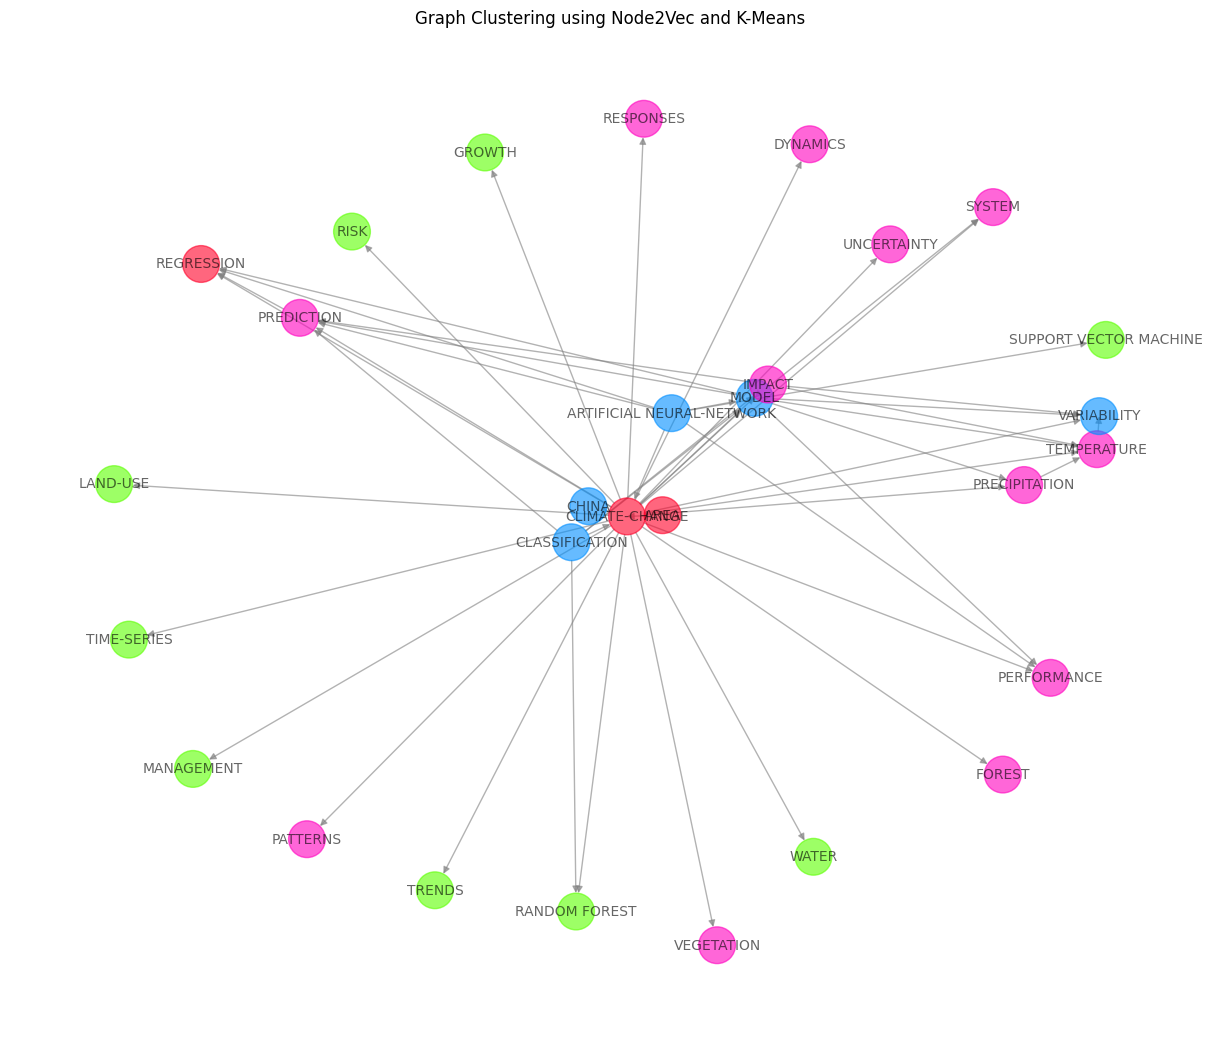

In [13]:
# Visualization
source = [i[0][0] for i in top_50_keyword_pairs]
target = [i[0][1] for i in top_50_keyword_pairs]
edge = [i[1] for i in top_50_keyword_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':edge})

# create a directed-graph
G=nx.from_pandas_edgelist(kg_df, "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())
pos = nx.spring_layout(G)

# Generate node embeddings using node2vec
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4) # parameters
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Get embeddings for all nodes
embeddings = np.array([model.wv[node] for node in G.nodes()])

# Perform K-Means clustering on node embeddings
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Visualize clusters
plt.figure(figsize=(12, 10))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, node_color=cluster_labels, cmap="gist_rainbow", edge_color='gray', alpha=0.6)
plt.title('Graph Clustering using Node2Vec and K-Means')

plt.show()

### 11. Bigrams on Abstracts

In [14]:
# Stop words chosen manually
stops = ["a", "and", "it", "the", "of", "in", "to", "this", "that",
         "is", "for", "we", "be", "our", "on", "from", "by", "under", "which", "over",
         "results", "used", "study", "does", "did", "do", "used", "we", "show"]

# Function to extract bigrams
def extract_bigrams(abstract):
    tokens = word_tokenize(str(abstract))
    words = [word for word in tokens if word.isalpha()]
    words = list(map(str.lower,words))
    clean = [word for word in words if not any(stop in word for stop in stops)]
    return list(bigrams(clean))

climate['Bigrams'] = climate['Abstract'].apply(extract_bigrams)

# Remove bigrams with duplicates
climate['Bigrams'] = [[bigram for bigram in sublist if bigram[0] != bigram[1]] for sublist in climate['Bigrams']]

# Normalize bigram
def normalize_bigram(bigram_list):
    normalized_list = []
    for bigram in bigram_list:
        bigram_str = ' '.join(bigram)
        if bigram_str == 'models model' or bigram_str == 'model models':
            continue

        normalization_map = {
            'rf models': 'rf model',  # Normalize to the singular form
            'neural networks': 'neural network',
            'ml model': 'ml models'
        }
        normalized_bigram_str = normalization_map.get(bigram_str, bigram_str)
        normalized_list.append(tuple(normalized_bigram_str.split()))
    return normalized_list

# Normalize bigrams in the DataFrame
climate['Bigrams'] = [normalize_bigram(sublist) for sublist in climate['Bigrams']]
all_bigrams = [bigram for sublist in climate['Bigrams'] for bigram in sublist]

# Count the occurrences of each bigram
bigram_counts = Counter(all_bigrams)

# Get the most common bigrams
most_common_bigrams = bigram_counts.most_common()

first_50_bigrams = most_common_bigrams[:50]
pprint(first_50_bigrams)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(('ml', 'models'), 780),
 (('time', 'series'), 645),
 (('root', 'error'), 538),
 (('degrees', 'c'), 482),
 (('rf', 'model'), 435),
 (('error', 'rmse'), 424),
 (('support', 'svm'), 370),
 (('extreme', 'events'), 276),
 (('proposed', 'model'), 274),
 (('crop', 'yield'), 268),
 (('hybrid', 'model'), 229),
 (('model', 'predict'), 225),
 (('proposed', 'method'), 223),
 (('soil', 'properties'), 221),
 (('models', 'predict'), 206),
 (('ensemble', 'model'), 204),
 (('memory', 'lstm'), 202),
 (('predictive', 'models'), 195),
 (('three', 'models'), 192),
 (('remotely', 'sensed'), 189),
 (('previous', 'studies'), 184),
 (('ml', 'methods'), 174),
 (('network', 'model'), 174),
 (('support', 'svr'), 168),
 (('c', 'elsevier'), 167),
 (('deep', 'network'), 164),
 (('models', 'developed'), 161),
 (('different', 'types'), 153),
 (('different', 'models'), 153),
 (('model', 'developed'), 151),
 (('very', 'high'), 145),
 (('lstm', 'model'), 144),
 (('ml', 'techniques'), 141),
 (('three', 'different'), 141

In [15]:
climate_bigrams = []
for pair in most_common_bigrams:
  if (pair[0][0] == 'climate') or (pair[0][1] == 'climate'):
    climate_bigrams.add(pair)

print(climate_bigrams) ## none

[]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


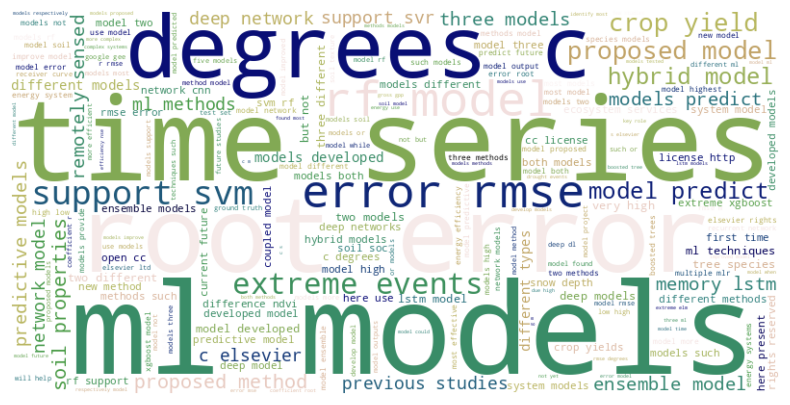

In [16]:
# Visualization
bigram_strings = {' '.join(bigram): count for bigram, count in bigram_counts.items()}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap="gist_earth_r").generate_from_frequencies(bigram_strings)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 12. Latent Dirichlet Allocation (LDA) - on Abstracts

In [20]:
def remove_special_characters(s):
  return ''.join(ch for ch in s if ch not in string.punctuation)

climate['Cleaned_Abstract'] = climate['Abstract'].fillna("").astype(str).apply(remove_special_characters)

data = climate['Cleaned_Abstract'].fillna("")

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Function to lemmatize and remove stopwords from the text data
def preprocess(text):
    text = text.lower()
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return words

data = data.apply(preprocess)
data

# Create a dictionary from the preprocessed data
dictionary = Dictionary(data)

# Filter out words that appear in fewer than 5 documents
dictionary.filter_extremes(no_below=5)

bow_corpus = [dictionary.doc2bow(text) for text in data]

# Train the LDA model
num_topics = 7 # For our paper
ldamodel = LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=20, alpha='auto', eta='auto')

# Get the topics
topics = ldamodel.show_topics(num_topics=num_topics, num_words=10, log=False, formatted=False)

# Print the topics
for topic_id, topic in topics:
    print("Topic: {}".format(topic_id))
    print("Words: {}".format([word for word, _ in topic]))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic: 0
Words: ['yield', 'crop', 'forecast', 'prediction', 'system', 'approach', 'production', 'food', 'agricultural', 'change']
Topic: 1
Words: ['satellite', 'resolution', 'remote', 'spatial', 'forest', 'sensing', 'accuracy', 'product', 'vegetation', 'surface']
Topic: 2
Words: ['method', 'network', 'approach', 'neural', 'system', 'prediction', 'used', 'time', 'algorithm', 'feature']
Topic: 3
Words: ['change', 'temperature', 'specie', 'region', 'global', 'distribution', 'effect', 'future', 'across', 'pattern']
Topic: 4
Words: ['soil', 'water', 'prediction', 'performance', 'regression', 'used', 'variable', 'mean', 'error', 'method']
Topic: 5
Words: ['energy', 'urban', 'emission', 'building', 'change', 'system', 'power', 'city', 'research', 'analysis']
Topic: 6
Words: ['area', 'forest', 'land', 'fire', 'flood', 'change', 'map', 'risk', 'random', 'used']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



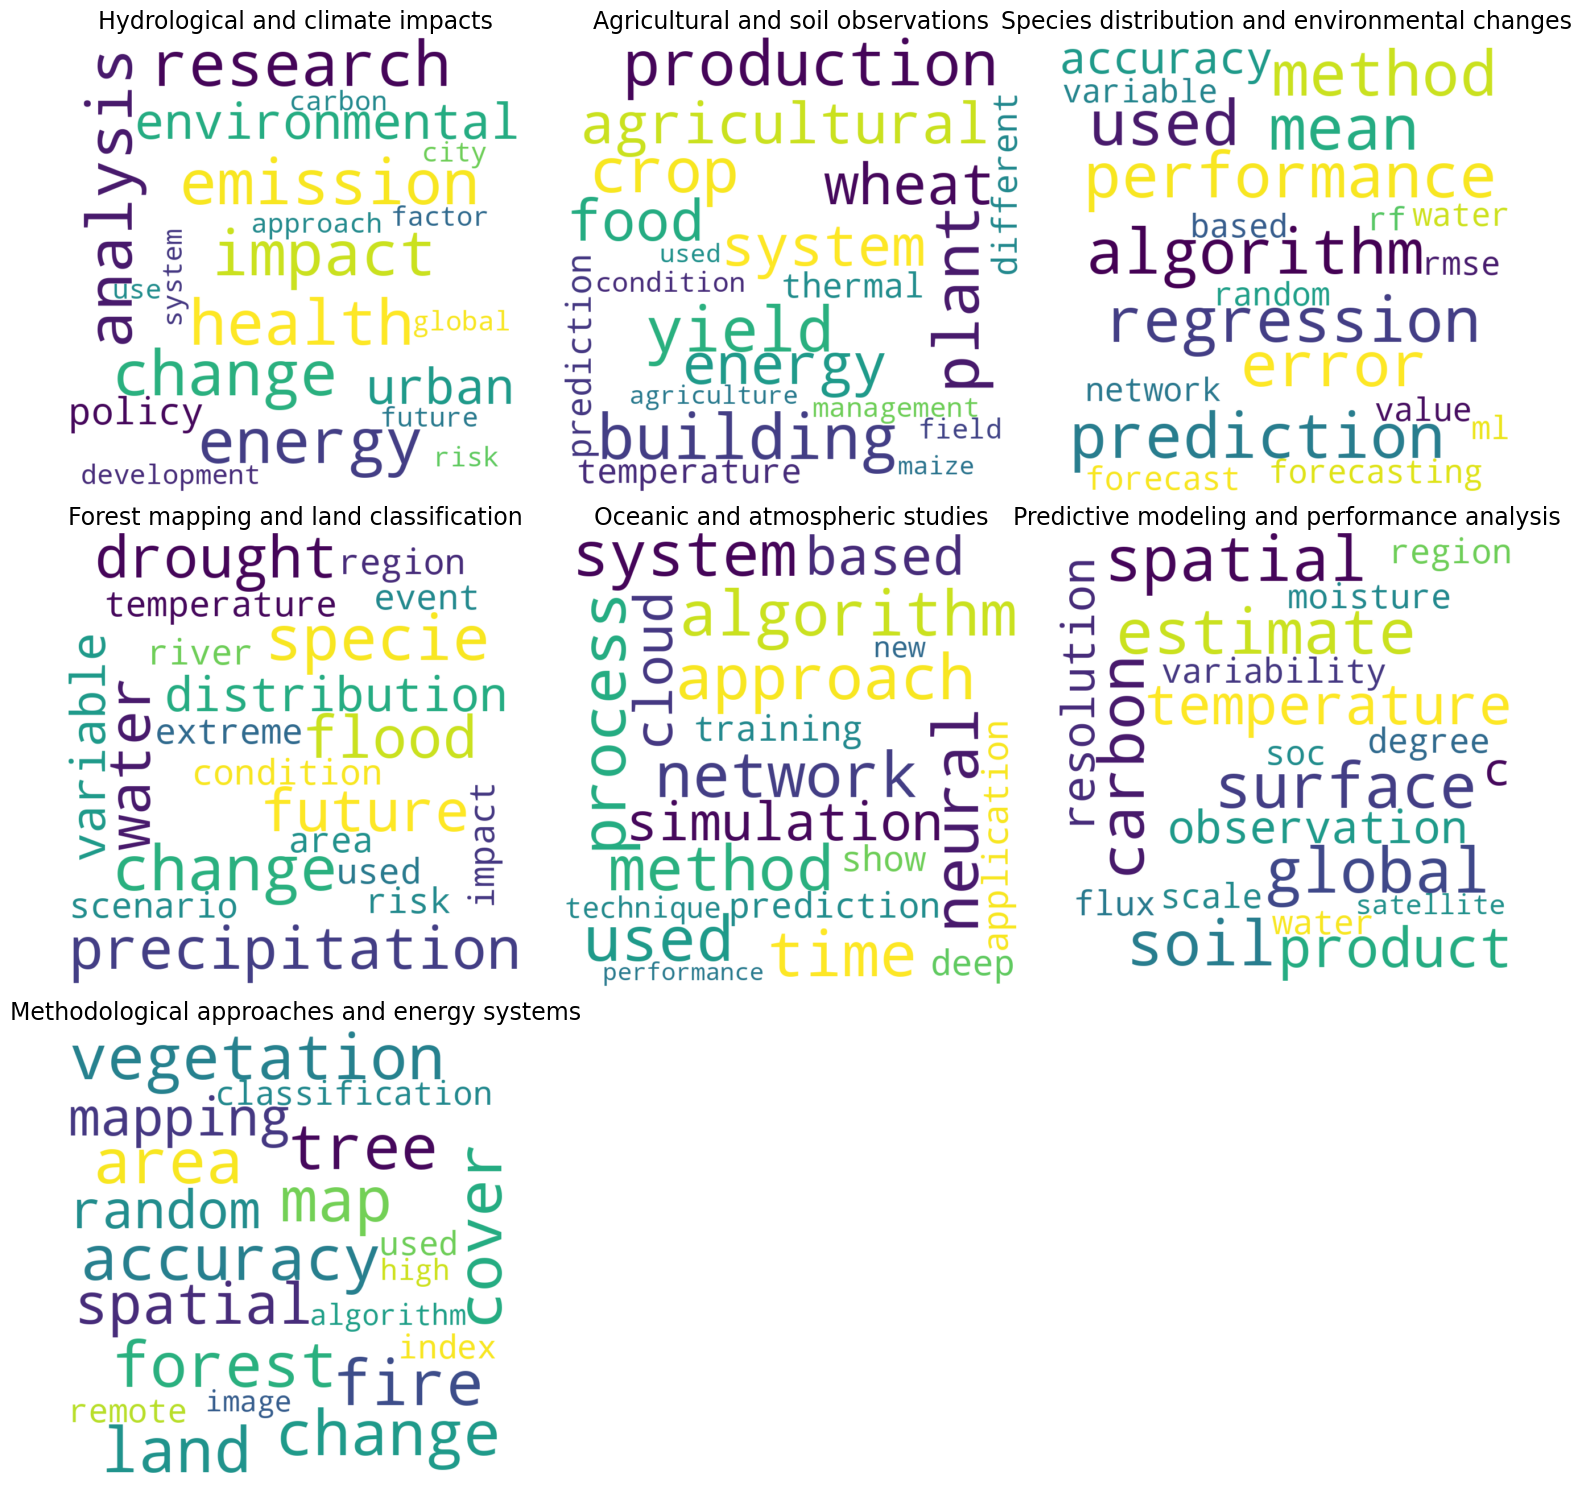

In [68]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

topic_titles = [
    "Hydrological and climate impacts",
    "Agricultural and soil observations",
    "Species distribution and environmental changes",
    "Forest mapping and land classification",
    "Oceanic and atmospheric studies",
    "Predictive modeling and performance analysis",
    "Methodological approaches and energy systems"
]

# Word Clouds for each Topic
for topic_id, topic in enumerate(ldamodel.print_topics(num_topics=num_topics, num_words=20)):
    topic_words = " ".join([word.split("*")[1].strip() for word in topic[1].split(" + ")])
    wordcloud = WordCloud(
        width=800,
        height=800,
        random_state=21,
        max_font_size=110,
        colormap="viridis",
        background_color="white"
    ).generate(topic_words)

    axes[topic_id].imshow(wordcloud, interpolation="bilinear")
    axes[topic_id].axis("off")
    axes[topic_id].set_title(topic_titles[topic_id], fontsize=17)

for i in range(num_topics, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
## Coherence scores
# Define the range of topics to evaluate
min_topics = 2
max_topics = 20
topics_range = range(min_topics, max_topics + 1)

"""
corpus = bow_corpus
dictionary = dictionary
"""
tokenized_docs = data

coherence_scores = []

# Calculate the coherence scores for each number of topics
for num_topics in topics_range:
    lda_model = LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)
    coherence_model = CoherenceModel(model=lda_model, texts=data, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    print(f'Num Topics: {num_topics}, Coherence Score: {coherence_score:.4f}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



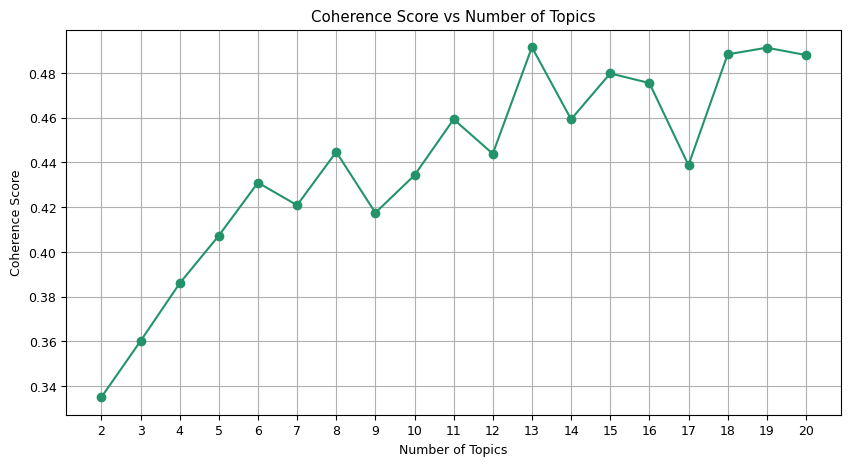

In [69]:
# Plotting the coherence scores
# same numbers, but wrote again
new_coherences = [0.3351, 0.3602, 0.3860, 0.4073,
                  0.4310, 0.4209, 0.4447, 0.4175,
                  0.4343, 0.4593, 0.4439, 0.4915,
                  0.4593, 0.4798, 0.4755, 0.4388,
                  0.4883, 0.4913, 0.4880]
new_topics_range = range(2, 21)
plt.figure(figsize=(10, 5))
plt.plot(new_topics_range, new_coherences, marker='o', color='#23946a')
plt.title('Coherence Score vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(new_topics_range)
plt.grid()
plt.show()

In [70]:
# pyLDAvis
# Creating Topic Distance Visualization
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, bow_corpus, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.053098 -0.101568       1        1  19.750024
3     -0.032692  0.116283       2        1  16.798115
2     -0.051994 -0.185659       3        1  16.793901
6     -0.071038  0.063535       4        1  14.191159
5     -0.195510  0.046099       5        1  12.822158
0      0.171309  0.118970       6        1  12.472731
1      0.126828 -0.057661       7        1   7.171912, topic_info=           Term         Freq        Total Category  logprob  loglift
153      forest  5149.000000  5149.000000  Default  30.0000  30.0000
1032       soil  3601.000000  3601.000000  Default  29.0000  29.0000
1511      yield  1980.000000  1980.000000  Default  28.0000  28.0000
230        crop  1639.000000  1639.000000  Default  27.0000  27.0000
11         area  5001.000000  5001.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
10     approach   319.070861  4595.076139   Topic7  -5.4938  -0.0323
85       method   327.563003  6376.244358   Topic7  -5.4676  -0.3337
7     algorithm   307.850729  4416.375006   Topic7  -5.5296  -0.0285
301         use   288.366522  2738.329956   Topic7  -5.5950   0.3841
2      accuracy   290.973360  3863.531872   Topic7  -5.5860   0.0489

[578 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1248      1  0.981050           2d
1190      5  0.996745  aboveground
748       1  0.009417     absolute
748       3  0.945516     absolute
748       5  0.045204     absolute
...     ...       ...          ...
1186      7  0.008897      xgboost
1511      1  0.034337        yield
1511      5  0.001515        yield
1511      7  0.963458        yield
3787      5  0.988526          yr1

[1446 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 7, 6, 1, 2])

In [21]:
## pyLDAvis for 19 topics = highest coherence score
lda_model_19 = LdaModel(bow_corpus, num_topics=19, id2word=dictionary, passes=15, random_state=42)
pyLDAvis.gensim.prepare(lda_model_19, bow_corpus, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.085998  0.144639       1        1  10.747276
17     0.120700  0.097819       2        1  10.410071
18    -0.122038 -0.077078       3        1   8.304422
2      0.163516 -0.092834       4        1   7.213103
0     -0.039948  0.101973       5        1   7.129933
4      0.178140  0.117655       6        1   6.599450
3     -0.122396  0.181011       7        1   5.138204
1     -0.038309 -0.144992       8        1   4.990665
15     0.100989 -0.138462       9        1   4.802569
6     -0.071305  0.039958      10        1   4.673451
12    -0.122879  0.065121      11        1   4.401552
9     -0.160812 -0.193840      12        1   4.287724
8      0.082416 -0.000208      13        1   4.054994
11    -0.006664 -0.044020      14        1   3.953502
7     -0.164319  0.090153      15        1   3.735303
14    -0.015846  0.082448      16        1   3.1704

In [23]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_19, bow_corpus, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.085998  0.144639       1        1  10.746780
17     0.120700  0.097819       2        1  10.410296
18    -0.122038 -0.077078       3        1   8.303832
2      0.163516 -0.092834       4        1   7.212957
0     -0.039948  0.101973       5        1   7.132015
4      0.178140  0.117655       6        1   6.598666
3     -0.122396  0.181011       7        1   5.137460
1     -0.038309 -0.144992       8        1   4.989853
15     0.100989 -0.138462       9        1   4.802963
6     -0.071305  0.039958      10        1   4.675191
12    -0.122879  0.065121      11        1   4.402243
9     -0.160812 -0.193840      12        1   4.286788
8      0.082416 -0.000208      13        1   4.055413
11    -0.006664 -0.044020      14        1   3.952847
7     -0.164319  0.090153      15        1   3.736189
14    -0.015846  0.082448      16        1   3.169985
16     0.100273 -0.130139      17        1   2.990006
5     -0.094135 -0.074109      18        1   1.725634
10     0.126618 -0.025092      19        1   1.670881, topic_info=            Term         Freq        Total Category  logprob  loglift
1032        soil  3638.000000  3638.000000  Default  30.0000  30.0000
308        water  3975.000000  3975.000000  Default  29.0000  29.0000
393       specie  2240.000000  2240.000000  Default  28.0000  28.0000
153       forest  5141.000000  5141.000000  Default  27.0000  27.0000
1511       yield  2062.000000  2062.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
66        hybrid    68.275429   724.032022  Topic19  -5.5789   1.7305
95    predictive    68.118847  1059.687148  Topic19  -5.5812   1.3473
794          set    68.393963  1621.271942  Topic19  -5.5771   0.9261
85        method    70.968197  6398.319883  Topic19  -5.5402  -0.4097
228    condition    66.576207  2223.876333  Topic19  -5.6041   0.5832

[1386 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1290      3  0.030502      1990
1290     12  0.960807      1990
599       3  0.171353      2000
599       5  0.050398      2000
599       7  0.065517      2000
...     ...       ...       ...
1511      2  0.036853     yield
1511     14  0.957702     yield
1511     16  0.005334     yield
7415     12  0.962119       yrd
8001      3  0.969082  zoonotic

[4873 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 18, 19, 3, 1, 5, 4, 2, 16, 7, 13, 10, 9, 12, 8, 15, 17, 6, 11])

In [72]:
# Get the 19 topics
topics_19 = lda_model.show_topics(num_topics=19, num_words=10, log=False, formatted=False)

# Print the topics
for topic_id, topic in topics_19:
    print("Topic: {}".format(topic_id))
    print("Words: {}".format([word for word, _ in topic]))

Topic: 0
Words: ['forest', 'vegetation', 'area', 'map', 'cover', 'remote', 'accuracy', 'sensing', 'land', 'mapping']
Topic: 1
Words: ['specie', 'change', 'distribution', 'future', 'habitat', 'scenario', 'environmental', 'ecological', 'area', 'potential']
Topic: 2
Words: ['research', 'analysis', 'approach', 'environmental', 'application', 'challenge', 'change', 'health', 'development', 'information']
Topic: 3
Words: ['product', 'global', 'resolution', 'surface', 'satellite', 'observation', 'ice', 'estimate', 'spatial', 'flux']
Topic: 4
Words: ['classification', 'image', 'method', 'accuracy', 'algorithm', 'feature', 'detection', 'used', 'based', 'sensor']
Topic: 5
Words: ['wind', 'solar', 'power', 'speed', 'energy', 'temperature', 'pv', 'radiation', 'humidity', 'load']
Topic: 6
Words: ['water', 'precipitation', 'river', 'flood', 'rainfall', 'flow', 'basin', 'hydrological', 'streamflow', 'catchment']
Topic: 7
Words: ['ocean', 'concentration', 'aerosol', 'observation', 'surface', 'cloud', 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

